In [15]:
import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

In [16]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [17]:
cmip6_models = ['bcc-csm2-mr', 'bcc-esm1', 'canesm5', \
                'kace-1-0-g', 'ipsl-cm6a-lr', 'miroc6', \
                'mri-esm2-0', 'noresm2-lm']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)


In [18]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [19]:
era5_max_deciles = xr.open_dataset('%s/era5_tw_max_deciles.nc'%dirHeatData)
lat = era5_max_deciles.latitude.values
lon = era5_max_deciles.longitude.values

In [20]:
sacksMaizeNc = xr.open_dataset('%s/sacks/Maize.crop.calendar.fill.nc'%dirAgData)
sacksStart = sacksMaizeNc['plant'].values
sacksStart = np.roll(sacksStart, -int(sacksStart.shape[1]/2), axis=1)
sacksStart[sacksStart < 0] = np.nan
sacksEnd = sacksMaizeNc['harvest'].values
sacksEnd = np.roll(sacksEnd, -int(sacksEnd.shape[1]/2), axis=1)
sacksEnd[sacksEnd < 0] = np.nan

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

# regrid sacks data
regridMesh = xr.Dataset({'lat': (['lat'], lat),
                         'lon': (['lon'], lon),})

regridder_start = xe.Regridder(xr.DataArray(data=sacksStart, dims=['lat', 'lon'], coords={'lat':sacksLat, 'lon':sacksLon}), regridMesh, 'bilinear', reuse_weights=True)
regridder_end = xe.Regridder(xr.DataArray(data=sacksEnd, dims=['lat', 'lon'], coords={'lat':sacksLat, 'lon':sacksLon}), regridMesh, 'bilinear', reuse_weights=True)

sacksStart_regrid = regridder_start(sacksStart)
sacksEnd_regrid = regridder_end(sacksEnd)


Reuse existing file: bilinear_360x720_721x1440.nc
Reuse existing file: bilinear_360x720_721x1440.nc


In [21]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
N_gridcells = np.where((land_sea_mask.lsm[0,:,:].values.reshape([lat.size*lon.size]))>0)[0].size

In [22]:
era5_txx_maize = xr.Dataset()
era5_sm_on_txx_maize = xr.Dataset()
era5_et_on_txx_maize = xr.Dataset()
era5_tmean_maize = xr.Dataset()
era5_tmean_soy = xr.Dataset()
era5_tmean_wheat = xr.Dataset()

for y,year in enumerate(range(1981,2020+1)):
    
    cur_era5_txx = xr.open_dataset('era5_txx_tmean/era5_Maize_txx_grow_%d.nc'%year)
    cur_era5_txx = cur_era5_txx.assign_coords({'time':year})
    if y == 0:
        era5_txx_maize = cur_era5_txx
    else:
        era5_txx_maize = xr.concat([era5_txx_maize, cur_era5_txx], dim='time')
        
    cur_era5_sm_on_txx = xr.open_dataset('era5_txx_tmean/era5_Maize_sm_on_txx_grow_%d.nc'%year)
    cur_era5_sm_on_txx = cur_era5_sm_on_txx.assign_coords({'time':year})
    if y == 0:
        era5_sm_on_txx_maize = cur_era5_sm_on_txx
    else:
        era5_sm_on_txx_maize = xr.concat([era5_sm_on_txx_maize, cur_era5_sm_on_txx], dim='time')


    cur_era5_et_on_txx = xr.open_dataset('era5_txx_tmean/era5_Maize_et_on_txx_grow_%d.nc'%year)
    cur_era5_et_on_txx = cur_era5_et_on_txx.assign_coords({'time':year})
    cur_era5_et_on_txx = 1-cur_era5_et_on_txx
    if y == 0:
        era5_et_on_txx_maize = cur_era5_et_on_txx
    else:
        era5_et_on_txx_maize = xr.concat([era5_et_on_txx_maize, cur_era5_et_on_txx], dim='time')
        
        
        
#     cur_era5_txx = xr.open_dataset('era5_txx_tmean/era5_Maize_txx_%d.nc'%year)
#     cur_era5_txx = cur_era5_txx.assign_coords({'time':year})
#     if y == 0:
#         era5_txx_maize = cur_era5_txx
#     else:
#         era5_txx_maize = xr.concat([era5_txx_maize, cur_era5_txx], dim='time')
        
#     cur_era5_sm_on_txx = xr.open_dataset('era5_txx_tmean/era5_Maize_sm_on_txx_%d.nc'%year)
#     cur_era5_sm_on_txx = cur_era5_sm_on_txx.assign_coords({'time':year})
#     if y == 0:
#         era5_sm_on_txx_maize = cur_era5_sm_on_txx
#     else:
#         era5_sm_on_txx_maize = xr.concat([era5_sm_on_txx_maize, cur_era5_sm_on_txx], dim='time')


#     cur_era5_et_on_txx = xr.open_dataset('era5_txx_tmean/era5_Maize_et_on_txx_%d.nc'%year)
#     cur_era5_et_on_txx = cur_era5_et_on_txx.assign_coords({'time':year})
# cur_era5_et_on_txx = 1-cur_era5_et_on_txx
#     if y == 0:
#         era5_et_on_txx_maize = cur_era5_et_on_txx
#     else:
#         era5_et_on_txx_maize = xr.concat([era5_et_on_txx_maize, cur_era5_et_on_txx], dim='time')
    
        
    if year <= 2016:
        cur_era5_tmean_maize = xr.open_dataset('era5_txx_tmean/era5_Maize_t_mean_grow_%d.nc'%year)
        cur_era5_tmean_maize = cur_era5_tmean_maize.assign_coords({'time':year})
        if y == 0:
            era5_tmean_maize = cur_era5_tmean_maize
        else:
            era5_tmean_maize = xr.concat([era5_tmean_maize, cur_era5_tmean_maize], dim='time')

        cur_era5_tmean_soy = xr.open_dataset('era5_txx_tmean/era5_Soybeans_t_mean_grow_%d.nc'%year)
        cur_era5_tmean_soy = cur_era5_tmean_soy.assign_coords({'time':year})
        if y == 0:
            era5_tmean_soy = cur_era5_tmean_soy
        else:
            era5_tmean_soy = xr.concat([era5_tmean_soy, cur_era5_tmean_soy], dim='time')


        cur_era5_tmean_wheat = xr.open_dataset('era5_txx_tmean/era5_Wheat_t_mean_grow_%d.nc'%year)
        cur_era5_tmean_wheat = cur_era5_tmean_wheat.assign_coords({'time':year})
        if y == 0:
            era5_tmean_wheat = cur_era5_tmean_wheat
        else:
            era5_tmean_wheat = xr.concat([era5_tmean_wheat, cur_era5_tmean_wheat], dim='time')

era5_txx_maize.load()
era5_sm_on_txx_maize.load()
era5_et_on_txx_maize.load()
era5_tmean_maize.load()
era5_tmean_soy.load()
era5_tmean_wheat.load()
# era5_txx.load()

<xarray.Dataset>
Dimensions:           (lat: 721, lon: 1440, time: 36)
Coordinates:
  * time              (time) int64 1981 1982 1983 1984 ... 2013 2014 2015 2016
  * lat               (lat) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon               (lon) float32 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    tasmax_grow_mean  (time, lat, lon) float64 nan nan nan ... -44.22 -44.22

In [23]:
txx_chg_81 = np.nanmean(era5_txx_maize.sel(time=slice(2000,2021)).tasmax_grow_max.values,axis=0) - np.nanmean(era5_txx_maize.sel(time=slice(1981,2001)).tasmax_grow_max.values,axis=0)
sm_on_txx_chg_81 = np.nanmean(era5_sm_on_txx_maize.sel(time=slice(2000,2021)).sm_grow_on_tmax.values,axis=0) - np.nanmean(era5_sm_on_txx_maize.sel(time=slice(1981,2001)).sm_grow_on_tmax.values,axis=0)
et_on_txx_chg_81 = np.nanmean(era5_et_on_txx_maize.sel(time=slice(2000,2021)).et_grow_on_tmax.values,axis=0) - np.nanmean(era5_et_on_txx_maize.sel(time=slice(1981,2001)).et_grow_on_tmax.values,axis=0)

tmean_chg_81 = np.nanmean(era5_tmean_maize.sel(time=slice(2000,2021)).tasmax_grow_mean.values,axis=0) - np.nanmean(era5_tmean_maize.sel(time=slice(1981,2001)).tasmax_grow_mean.values,axis=0)

# txx_chg_81 = np.nanmean(era5_txx.sel(time=slice(2000,2021)).tasmax_grow_max.values,axis=0)-np.nanmean(era5_txx.sel(time=slice(1981,2001)).tasmax_grow_max.values,axis=0)
# tmean_chg_81 = np.nanmean(era5_tmean.sel(time=slice(2000,2021)).tasmax_grow_mean.values,axis=0)-np.nanmean(era5_tmean.sel(time=slice(1981,2001)).tasmax_grow_mean.values,axis=0)
# txx_amp_81 = txx_chg_81-tmean_chg_81;

# txx_chg_71 = np.nanmean(era5_txx.sel(time=slice(1991,2011)).tasmax_grow_max.values,axis=0)-np.nanmean(era5_txx.sel(time=slice(1971,1991)).tasmax_grow_max.values,axis=0)
# tmean_chg_71 = np.nanmean(era5_tmean.sel(time=slice(1991,2011)).tasmax_grow_mean.values,axis=0)-np.nanmean(era5_tmean.sel(time=slice(1971,1991)).tasmax_grow_mean.values,axis=0)
# txx_amp_71 = txx_chg_71-tmean_chg_71;

# txx_chg_61 = np.nanmean(era5_txx.sel(time=slice(1981,2001)).tasmax_grow_max.values,axis=0)-np.nanmean(era5_txx.sel(time=slice(1961,1981)).tasmax_grow_max.values,axis=0)
# tmean_chg_61 = np.nanmean(era5_tmean.sel(time=slice(1981,2001)).tasmax_grow_mean.values,axis=0)-np.nanmean(era5_tmean.sel(time=slice(1961,1981)).tasmax_grow_mean.values,axis=0)
# txx_amp_61 = txx_chg_61-tmean_chg_61;

In [24]:
# for y, year in enumerate(range(1981, 2020+1)):
#     os.rename('%s/heat-wave-days/et-on-tw/era5_et_on_tw_%d.dat'%(dirHeatData, year), '%s/heat-wave-days/et-on-tw/era5_et_on_tw_%d_%d.dat'%(dirHeatData, 95, year))

In [25]:
%%time

rebuild = False
ca_year = 1995

if rebuild:# not os.path.isfile('maize_hw_%d_regrid.dat'%ca_year) and not rebuild:
    crop_ha_lat = np.linspace(90, -90, 2160)
    crop_ha_lon = np.linspace(0, 360, 4320)

    print('processing maize...')
    maize_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Maize/Maize_%d_Area.tif'%(dirAgData, ca_year))
    maize_ha = maize_ha.read(1)
    maize_ha[abs(maize_ha) > 10] = np.nan
    maize_ha = np.roll(maize_ha, -int(maize_ha.shape[1]/2), axis=1)
    
    regridMesh = xr.Dataset({'lat': (['lat'], np.linspace(90, -90, lat.size)),
                             'lon': (['lon'], np.linspace(0, 360, lon.size)),})

    regridder = xe.Regridder(xr.DataArray(data=maize_ha, dims=['lat', 'lon'], coords={'lat':crop_ha_lat, 'lon':crop_ha_lon}), regridMesh, 'bilinear')
    maize_ha_regrid = regridder(maize_ha)
    
    with open('maize_hw_%d_regrid.dat'%ca_year, 'wb') as f:
        pickle.dump(maize_ha_regrid, f)
        
    print('processing soy...')
    soy_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Soybean/Soybean_%d_Area.tif'%(dirAgData, ca_year))
    soy_ha = soy_ha.read(1)
    soy_ha[abs(soy_ha) > 10] = np.nan
    soy_ha = np.roll(soy_ha, -int(soy_ha.shape[1]/2), axis=1)
    
    regridder = xe.Regridder(xr.DataArray(data=soy_ha, dims=['lat', 'lon'], coords={'lat':crop_ha_lat, 'lon':crop_ha_lon}), regridMesh, 'bilinear')
    soy_ha_regrid = regridder(soy_ha)
    
    with open('soy_hw_%d_regrid.dat'%ca_year, 'wb') as f:
        pickle.dump(soy_ha_regrid, f)
      
    
    print('processing wheat...')
    wheat_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Wheat/Wheat_%d_Area.tif'%(dirAgData, ca_year))
    wheat_ha = wheat_ha.read(1)
    wheat_ha[abs(wheat_ha) > 10] = np.nan
    wheat_ha = np.roll(wheat_ha, -int(wheat_ha.shape[1]/2), axis=1)
    
    regridder = xe.Regridder(xr.DataArray(data=wheat_ha, dims=['lat', 'lon'], coords={'lat':crop_ha_lat, 'lon':crop_ha_lon}), regridMesh, 'bilinear')
    wheat_ha_regrid = regridder(wheat_ha)
    
    with open('wheat_hw_%d_regrid.dat'%ca_year, 'wb') as f:
        pickle.dump(wheat_ha_regrid, f)
    
    
    print('processing rice...')
    rice_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Rice/Rice_%d_Area.tif'%(dirAgData, ca_year))
    rice_ha = rice_ha.read(1)
    rice_ha[abs(rice_ha) > 10] = np.nan
    rice_ha = np.roll(rice_ha, -int(rice_ha.shape[1]/2), axis=1)
    
    regridder = xe.Regridder(xr.DataArray(data=rice_ha, dims=['lat', 'lon'], coords={'lat':crop_ha_lat, 'lon':crop_ha_lon}), regridMesh, 'bilinear')
    rice_ha_regrid = regridder(rice_ha)
    
    with open('rice_hw_%d_regrid.dat'%ca_year, 'wb') as f:
        pickle.dump(rice_ha_regrid, f)
else:
    with open('maize_hw_%d_regrid.dat'%1995, 'rb') as f:
        maize_ha_regrid_1995 = pickle.load(f)
    with open('maize_hw_%d_regrid.dat'%2000, 'rb') as f:
        maize_ha_regrid_2000 = pickle.load(f)
    with open('maize_hw_%d_regrid.dat'%2005, 'rb') as f:
        maize_ha_regrid_2005 = pickle.load(f)
        
        
    with open('soy_hw_%d_regrid.dat'%1995, 'rb') as f:
        soy_ha_regrid_1995 = pickle.load(f)
    with open('soy_hw_%d_regrid.dat'%2000, 'rb') as f:
        soy_ha_regrid_2000 = pickle.load(f)
    with open('soy_hw_%d_regrid.dat'%2005, 'rb') as f:
        soy_ha_regrid_2005 = pickle.load(f)
        
    
    with open('wheat_hw_%d_regrid.dat'%1995, 'rb') as f:
        wheat_ha_regrid_1995 = pickle.load(f)
    with open('wheat_hw_%d_regrid.dat'%2000, 'rb') as f:
        wheat_ha_regrid_2000 = pickle.load(f)
    with open('wheat_hw_%d_regrid.dat'%2005, 'rb') as f:
        wheat_ha_regrid_2005 = pickle.load(f)

        
#     crop_ha_regrid = maize_ha_regrid + soy_ha_regrid# + wheat_ha_regrid# + rice_ha_regrid
#     crop_ha_regrid *= 100
#     crop_ha_regrid[crop_ha_regrid>100] = 100

CPU times: user 17.6 ms, sys: 44.2 ms, total: 61.8 ms
Wall time: 2.17 s


In [26]:
# load iizumi
iizumi_maize_ds = xr.Dataset()
iizumi_soy_ds = xr.Dataset()
iizumi_wheat_ds = xr.Dataset()

for y,year in enumerate(range(1981,2016+1)):
    
    iizumi_maize_ds_cur= xr.open_dataset('%s/iizumi/maize_major/yield_%d.nc4'%(dirHeatData,year))
    iizumi_maize_ds_cur = iizumi_maize_ds_cur.assign_coords({'time':year})
    if y == 0:
        iizumi_maize_ds = iizumi_maize_ds_cur
    else:
        iizumi_maize_ds = xr.concat([iizumi_maize_ds, iizumi_maize_ds_cur], dim='time')
        
        
    iizumi_soy_ds_cur= xr.open_dataset('%s/iizumi/soybean/yield_%d.nc4'%(dirHeatData,year))
    iizumi_soy_ds_cur = iizumi_soy_ds_cur.assign_coords({'time':year})
    if y == 0:
        iizumi_soy_ds = iizumi_soy_ds_cur
    else:
        iizumi_soy_ds = xr.concat([iizumi_soy_ds, iizumi_soy_ds_cur], dim='time')
        

    iizumi_wheat_ds_cur= xr.open_dataset('%s/iizumi/wheat/yield_%d.nc4'%(dirHeatData,year))
    iizumi_wheat_ds_cur = iizumi_wheat_ds_cur.assign_coords({'time':year})
    if y == 0:
        iizumi_wheat_ds = iizumi_wheat_ds_cur
    else:
        iizumi_wheat_ds = xr.concat([iizumi_wheat_ds, iizumi_wheat_ds_cur], dim='time')

iizumi_maize_ds = iizumi_maize_ds.reindex(lat=list(reversed(iizumi_maize_ds.lat)))
iizumi_soy_ds = iizumi_soy_ds.reindex(lat=list(reversed(iizumi_soy_ds.lat)))
iizumi_wheat_ds = iizumi_wheat_ds.reindex(lat=list(reversed(iizumi_wheat_ds.lat)))

# regrid iizumi to era5
regridMesh = xr.Dataset({'lat': (['lat'], lat),
                         'lon': (['lon'], lon),})

regridder = xe.Regridder(iizumi_maize_ds, regridMesh, 'bilinear', reuse_weights=False)
regridder.clean_weight_file()
iizumi_maize_ds_regrid = regridder(iizumi_maize_ds)

regridder = xe.Regridder(iizumi_soy_ds, regridMesh, 'bilinear', reuse_weights=False)
regridder.clean_weight_file()
iizumi_soy_ds_regrid = regridder(iizumi_soy_ds)

regridder = xe.Regridder(iizumi_wheat_ds, regridMesh, 'bilinear', reuse_weights=False)
regridder.clean_weight_file()
iizumi_wheat_ds_regrid = regridder(iizumi_wheat_ds)

Overwrite existing file: bilinear_360x720_721x1440.nc 
 You can set reuse_weights=True to save computing time.
Remove file bilinear_360x720_721x1440.nc
using dimensions ('lat', 'lon') from data variable var as the horizontal dimensions for this dataset.
Create weight file: bilinear_360x720_721x1440.nc
Remove file bilinear_360x720_721x1440.nc
using dimensions ('lat', 'lon') from data variable var as the horizontal dimensions for this dataset.
Create weight file: bilinear_360x720_721x1440.nc
Remove file bilinear_360x720_721x1440.nc
using dimensions ('lat', 'lon') from data variable var as the horizontal dimensions for this dataset.


In [27]:
faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dirAgData
irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
irrigationLon[irrigationLon<0] += 360

regridMesh = xr.Dataset({'lat': (['lat'], lat),
                         'lon': (['lon'], lon),})

regridder_irr = xe.Regridder(xr.DataArray(data=irrigationData, dims=['lat', 'lon'], coords={'lat':irrigationLat, 'lon':irrigationLon}), regridMesh, 'bilinear', reuse_weights=True)

irrigationData_regrid = regridder_irr(irrigationData)
irrigationData_regrid_1d = irrigationData_regrid.reshape([irrigationData_regrid.size,1])

Reuse existing file: bilinear_2160x4320_721x1440.nc


In [28]:
with open('%s/cropped_area/crop_land_regrid_era5.dat'%(dirAg6), 'rb') as f:
    crop_ha_regrid = pickle.load(f)
    crop_ha_regrid_1d = crop_ha_regrid.reshape([crop_ha_regrid.size, 1])

In [218]:
ds_grow_r_t_et_total_evap_61_21 = xr.open_dataset('r_t_et_era5_total_evaporation_1961_2021_detrend.nc')
ds_grow_r_t_et_total_evap_61_21.load()

ds_grow_r_t_et_total_evap_61_81 = xr.open_dataset('r_t_et_era5_total_evaporation_1961_1980_detrend.nc')
ds_grow_r_t_et_total_evap_61_81.load()

ds_grow_r_t_et_total_evap_71_91 = xr.open_dataset('r_t_et_era5_total_evaporation_1971_1990_detrend.nc')
ds_grow_r_t_et_total_evap_71_91.load()

ds_grow_r_t_et_total_evap_81_01 = xr.open_dataset('r_t_et_era5_total_evaporation_1981_2001_detrend.nc')
ds_grow_r_t_et_total_evap_81_01.load()

ds_grow_r_t_et_total_evap_81_01_soy = xr.open_dataset('r_t_et_era5_total_evaporation_1981_2001_detrend-Soybeans.nc')
ds_grow_r_t_et_total_evap_81_01_soy.load()

ds_grow_r_t_et_total_evap_81_01_wheat = xr.open_dataset('r_t_et_era5_total_evaporation_1981_2001_detrend-Wheat.nc')
ds_grow_r_t_et_total_evap_81_01_wheat.load()

ds_grow_r_t_et_total_evap_91_11 = xr.open_dataset('r_t_et_era5_total_evaporation_1991_2010_detrend.nc')
ds_grow_r_t_et_total_evap_91_11.load()

ds_grow_r_t_et_total_evap_01_21 = xr.open_dataset('r_t_et_era5_total_evaporation_2001_2021_detrend.nc')
ds_grow_r_t_et_total_evap_01_21.load()

ds_grow_r_t_et_total_evap_01_21_soy = xr.open_dataset('r_t_et_era5_total_evaporation_2001_2021_detrend-Soybeans.nc')
ds_grow_r_t_et_total_evap_01_21_soy.load()

ds_grow_r_t_et_total_evap_01_21_wheat = xr.open_dataset('r_t_et_era5_total_evaporation_2001_2021_detrend-Wheat.nc')
ds_grow_r_t_et_total_evap_01_21_wheat.load()

ds_grow_r_t_et_total_evap_61_91 = xr.open_dataset('r_t_et_era5_total_evaporation_1961_1991_detrend.nc')
ds_grow_r_t_et_total_evap_61_91.load()

ds_grow_r_t_et_total_evap_91_21 = xr.open_dataset('r_t_et_era5_total_evaporation_1991_2021_detrend.nc')
ds_grow_r_t_et_total_evap_91_21.load()

ds_grow_r_t_et_total_evap_81_16 = xr.open_dataset('r_t_et_era5_total_evaporation_1981_2016_detrend.nc')
ds_grow_r_t_et_total_evap_81_16.load()

ds_grow_r_t_et_total_evap_81_16_soy = xr.open_dataset('r_t_et_era5_total_evaporation_1981_2016_detrend-Soybeans.nc')
ds_grow_r_t_et_total_evap_81_16_soy.load()

ds_grow_r_t_et_total_evap_81_16_wheat = xr.open_dataset('r_t_et_era5_total_evaporation_1981_2016_detrend-Wheat.nc')
ds_grow_r_t_et_total_evap_81_16_wheat.load()

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    r_t_et   (lat, lon) float64 nan nan nan nan ... -0.4697 -0.4697 -0.4697

In [30]:
yearRange = np.arange(1981, 2020+1)

In [31]:
tx_during_tw_cmip6 = xr.Dataset()
tw_during_tx_cmip6 = xr.Dataset()

percentiles = np.array([50, 80, 90, 95, 96, 97, 98, 99])

tx_during_tw = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)
tw_during_tx = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)
tx_during_tx = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)
tw_during_tw = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)

et_during_tw = np.full([len(yearRange), lat.size, lon.size], np.nan)
et_during_tx = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)

huss_during_tw = np.full([len(yearRange), lat.size, lon.size], np.nan)
huss_during_tx = np.full([len(yearRange), lat.size, lon.size], np.nan)

sm_during_tw = np.full([len(yearRange), lat.size, lon.size], np.nan)
sm_during_tx = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)

for y_ind, y in enumerate(yearRange):
    print(y)
    for p in range(percentiles.size):
        with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
            tw_during_tx[p, y_ind, :, :] = pickle.load(f)
        with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tw_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
            tx_during_tw[p, y_ind, :, :] = pickle.load(f)

        with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tw_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
            tw_during_tw[p, y_ind, :, :] = pickle.load(f)
        with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
            tx_during_tx[p, y_ind, :, :] = pickle.load(f)
            
        if os.path.isfile('%s/heat-wave-days/et-on-tx/era5_et_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y)):
            with open('%s/heat-wave-days/et-on-tx/era5_et_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
                et_during_tx[p, y_ind, :, :] = pickle.load(f)
                
        if os.path.isfile('%s/heat-wave-days/sm-on-tx/era5_sm_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y)):
            with open('%s/heat-wave-days/sm-on-tx/era5_sm_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
                sm_during_tx[p, y_ind, :, :] = pickle.load(f)
        
       
    with open('%s/heat-wave-days/et-on-tw/era5_et_on_tw_95_%d.dat'%(dirHeatData, y), 'rb') as f:
        et_during_tw[y_ind, :, :] = pickle.load(f)
        
    with open('%s/heat-wave-days/huss-on-tx/era5_huss_on_tx_%d.dat'%(dirHeatData, y), 'rb') as f:
        huss_during_tx[y_ind, :, :] = pickle.load(f)
    with open('%s/heat-wave-days/huss-on-tw/era5_huss_on_tw_%d.dat'%(dirHeatData, y), 'rb') as f:
        huss_during_tw[y_ind, :, :] = pickle.load(f)
        
        


1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [32]:
tx_during_tw_trend = np.full([lat.size, lon.size], np.nan)
tx_during_tw_pval = np.full([lat.size, lon.size], np.nan)

tw_during_tx_trend = np.full([lat.size, lon.size], np.nan)
tw_during_tx_pval = np.full([lat.size, lon.size], np.nan)

tx_during_tx_trend = np.full([lat.size, lon.size], np.nan)
tx_during_tx_pval = np.full([lat.size, lon.size], np.nan)

tw_during_tw_trend = np.full([lat.size, lon.size], np.nan)
tw_during_tw_pval = np.full([lat.size, lon.size], np.nan)

tx_diff_from_tw_during_tw_trend = np.full([lat.size, lon.size], np.nan)
tx_diff_from_tw_during_tw_pval = np.full([lat.size, lon.size], np.nan)

tw_diff_from_tx_during_tx_trend = np.full([lat.size, lon.size], np.nan)
tw_diff_from_tx_during_tx_pval = np.full([lat.size, lon.size], np.nan)

et_during_tw_trend = np.full([lat.size, lon.size], np.nan)
et_during_tw_pval = np.full([lat.size, lon.size], np.nan)

et_during_tx_trend = np.full([lat.size, lon.size], np.nan)
et_during_tx_pval = np.full([lat.size, lon.size], np.nan)

huss_during_tw_trend = np.full([lat.size, lon.size], np.nan)
huss_during_tw_pval = np.full([lat.size, lon.size], np.nan)

huss_during_tx_trend = np.full([lat.size, lon.size], np.nan)
huss_during_tx_pval = np.full([lat.size, lon.size], np.nan)

with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tw_trend.dat'%(dirHeatData), 'rb') as f:
    tx_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tx_during_tw_pval = pickle.load(f)
    
with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tx_trend.dat'%(dirHeatData), 'rb') as f:
    tw_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tw_during_tx_pval = pickle.load(f)
    
    
with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tx_trend.dat'%(dirHeatData), 'rb') as f:
    tx_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tx_during_tx_pval = pickle.load(f)
    
with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tw_trend.dat'%(dirHeatData), 'rb') as f:
    tw_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tw_during_tw_pval = pickle.load(f)
    
    
with open('%s/heat-wave-days/tx-on-tw/era5_tx_diff_from_tw_during_tw_trend.dat'%(dirHeatData), 'rb') as f:
    tx_diff_from_tw_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/tx-on-tw/era5_tx_diff_from_tw_during_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tx_diff_from_tw_during_tw_pval = pickle.load(f)
    
with open('%s/heat-wave-days/tw-on-tx/era5_tw_diff_from_tx_during_tx_trend.dat'%(dirHeatData), 'rb') as f:
    tw_diff_from_tx_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/tw-on-tx/era5_tw_diff_from_tx_during_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tw_diff_from_tx_during_tx_pval = pickle.load(f)
    
    
with open('%s/heat-wave-days/et-on-tw/era5_et_on_tw_trend.dat'%(dirHeatData), 'rb') as f:
    et_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/et-on-tw/era5_et_on_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    et_during_tw_pval = pickle.load(f)
    
with open('%s/heat-wave-days/et-on-tx/era5_et_on_tx_trend.dat'%(dirHeatData), 'rb') as f:
    et_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/et-on-tx/era5_et_on_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    et_during_tx_pval = pickle.load(f)
    
    
with open('%s/heat-wave-days/huss-on-tw/era5_huss_on_tw_trend.dat'%(dirHeatData), 'rb') as f:
    huss_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/huss-on-tw/era5_huss_on_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    huss_during_tw_pval = pickle.load(f)
    
with open('%s/heat-wave-days/huss-on-tx/era5_huss_on_tx_trend.dat'%(dirHeatData), 'rb') as f:
    huss_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/huss-on-tx/era5_huss_on_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    huss_during_tx_pval = pickle.load(f)
    

In [33]:
r_t_et_cmip6_1981_2000 = xr.Dataset()
r_t_et_cmip6_2000_2015 = xr.Dataset()
for m, model in enumerate(cmip6_models):
    
    
    
    if os.path.isfile('r_t_et/cmip6_r_t_et_grow_Maize_global_%s_1981_2000_fixed_sh.nc'%(model)):
        print('loading %s'%model)
        ds_r_t_et_1981_2000 = xr.open_dataset('r_t_et/cmip6_r_t_et_grow_Maize_global_%s_1981_2000_fixed_sh.nc'%(model))
    
        if m == 0:
            r_t_et_cmip6_1981_2000 = ds_r_t_et_1981_2000
        else:
            r_t_et_cmip6_1981_2000 = xr.concat([r_t_et_cmip6_1981_2000, ds_r_t_et_1981_2000], dim='model')
            
    if os.path.isfile('r_t_et/cmip6_r_t_et_grow_Maize_global_%s_2000_2015_fixed_sh.nc'%(model)):
        print('loading %s'%model)
        ds_r_t_et_2000_2015 = xr.open_dataset('r_t_et/cmip6_r_t_et_grow_Maize_global_%s_2000_2015_fixed_sh.nc'%(model))
    
        if m == 0:
            r_t_et_cmip6_2000_2015 = ds_r_t_et_2000_2015
        else:
            r_t_et_cmip6_2000_2015 = xr.concat([r_t_et_cmip6_2000_2015, ds_r_t_et_2000_2015], dim='model')


loading bcc-csm2-mr
loading bcc-csm2-mr
loading canesm5
loading canesm5
loading kace-1-0-g
loading kace-1-0-g
loading ipsl-cm6a-lr
loading ipsl-cm6a-lr
loading miroc6
loading miroc6


In [34]:
# compare era5 r(t, et) to cmip in 1981 - 2001

cmip6_era5_r_t_et_anom_1981_2000 = np.full([r_t_et_cmip6_1981_2000.r_t_et.lat.size, r_t_et_cmip6_1981_2000.r_t_et.lon.size, r_t_et_cmip6_1981_2000.r_t_et.model.size], np.nan)
cmip6_era5_r_t_et_anom_2000_2015 = np.full([r_t_et_cmip6_2000_2015.r_t_et.lat.size, r_t_et_cmip6_2000_2015.r_t_et.lon.size, r_t_et_cmip6_2000_2015.r_t_et.model.size], np.nan)

newLat = np.arange(-90, 90, 1.5)
newLon = np.arange(0, 360, 1.5)

# regrid era5 data to cmip6 res
regridMesh = xr.Dataset({'lat': (['lat'], newLat),
                         'lon': (['lon'], newLon),})

regridder = xe.Regridder(ds_grow_r_t_et_total_evap_81_01, regridMesh, 'bilinear', reuse_weights=True)
regridder.clean_weight_file()
ds_grow_r_t_et_total_evap_81_01_regrid = regridder(ds_grow_r_t_et_total_evap_81_01)

regridder = xe.Regridder(ds_grow_r_t_et_total_evap_01_21, regridMesh, 'bilinear', reuse_weights=True)
regridder.clean_weight_file()
ds_grow_r_t_et_total_evap_01_21_regrid = regridder(ds_grow_r_t_et_total_evap_01_21)

for m in range(r_t_et_cmip6_1981_2000.r_t_et.model.size):
    cmip6_era5_r_t_et_anom_1981_2000[:,:,m] = r_t_et_cmip6_1981_2000.r_t_et.values[m,:,:] - ds_grow_r_t_et_total_evap_81_01_regrid.r_t_et.values
    cmip6_era5_r_t_et_anom_2000_2015[:,:,m] = r_t_et_cmip6_2000_2015.r_t_et.values[m,:,:] - ds_grow_r_t_et_total_evap_01_21_regrid.r_t_et.values

Create weight file: bilinear_721x1440_120x240.nc
Remove file bilinear_721x1440_120x240.nc
using dimensions ('lat', 'lon') from data variable r_t_et as the horizontal dimensions for this dataset.
Create weight file: bilinear_721x1440_120x240.nc
Remove file bilinear_721x1440_120x240.nc
using dimensions ('lat', 'lon') from data variable r_t_et as the horizontal dimensions for this dataset.


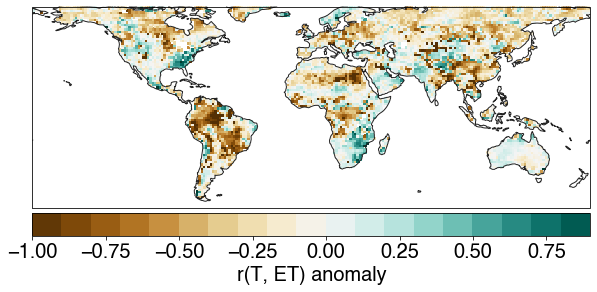

In [35]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -1
v2 = 1
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(cmip6_era5_r_t_et_anom_1981_2000[:,:,:], axis=2)
# data = np.nanmean(cmip6_era5_r_t_et_anom_2000_2015[:,:,:], axis=2)

# data = np.nanmean(r_t_et_cmip6_2000_2015.r_t_et.values-r_t_et_cmip6_1981_2000.r_t_et.values,axis=0)

c = plt.pcolormesh(newLon, newLat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(T, ET) anomaly', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [36]:
# for m, model in enumerate(cmip6_models):
#     print('loading %s'%model)
    
#     tx_during_tw_cur_model = xr.Dataset()
#     tw_during_tx_cur_model = xr.Dataset()
    
#     for y_ind, y in enumerate(yearRange):
#         ds_tw_on_tx = xr.open_dataset('%s/heat-wave-days/tw-on-tx/cmip6/%s/cmip6_tw_on_tx_%d_%s.nc'%(dirHeatData, model, y, model))
#         ds_tx_on_tw = xr.open_dataset('%s/heat-wave-days/tx-on-tw/cmip6/%s/cmip6_tx_on_tw_%d_%s.nc'%(dirHeatData, model, y, model))
    
#         if y_ind == 0:
#             tx_during_tw_cur_model = ds_tx_on_tw
#             tw_during_tx_cur_model = ds_tw_on_tx
#         else:
#             tx_during_tw_cur_model = xr.concat([tx_during_tw_cur_model, ds_tx_on_tw], dim='time')
#             tw_during_tx_cur_model = xr.concat([tw_during_tx_cur_model, ds_tw_on_tx], dim='time')
    
#     if m == 0:
#         tx_during_tw_cmip6 = tx_during_tw_cur_model
#         tw_during_tx_cmip6 = tw_during_tx_cur_model
#     else:
#         tx_during_tw_cmip6 = xr.concat([tx_during_tw_cmip6, tx_during_tw_cur_model], dim='model')
#         tw_during_tx_cmip6 = xr.concat([tw_during_tx_cmip6, tw_during_tx_cur_model], dim='model')

In [37]:
# plt.figure(figsize=(10,10))
# ax = plt.axes(projection=ccrs.PlateCarree())

# ax.set_extent([-180, -180, 70, -60])

# v1 = 0
# v2 = 1.01
# vstep = .1
# vlabelstep = .25

# midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
# cmap = plt.cm.get_cmap('Reds')

# # data = ds_grow_r_t_et.r_t_et.values
# data = np.nanmean(tx_during_tw, axis=0)
# c = plt.pcolormesh(lon, lat, data, \
#                  cmap=cmap, norm=midnorm)

# ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# # plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
# scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=25, shrink=1)
# cb.ax.tick_params(labelsize=20)
# cb.set_label('Tx during Tw (Percentile)', fontsize=20)

# # plt.savefig('r-t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [38]:
# plt.figure(figsize=(10,10))
# ax = plt.axes(projection=ccrs.PlateCarree())

# ax.set_extent([-180, -180, 70, -60])

# v1 = -.01
# v2 = .011
# vstep = .001
# vlabelstep = .005

# midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
# cmap = plt.cm.get_cmap('bwr')

# # data = ds_grow_r_t_et.r_t_et.values
# data = tx_during_tx_trend * 10
# c = plt.pcolormesh(lon, lat, data, \
#                  cmap=cmap, norm=midnorm)

# ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# # plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
# scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=25, shrink=1)
# cb.ax.tick_params(labelsize=20)
# cb.set_label('Trend in Tx during Tx (Percentile/decade)', fontsize=20)

# # plt.savefig('r-t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [39]:
maize_chg = maize_ha_regrid_2005-maize_ha_regrid_1995
soy_chg = soy_ha_regrid_2005-soy_ha_regrid_1995
wheat_chg = wheat_ha_regrid_2005-wheat_ha_regrid_1995

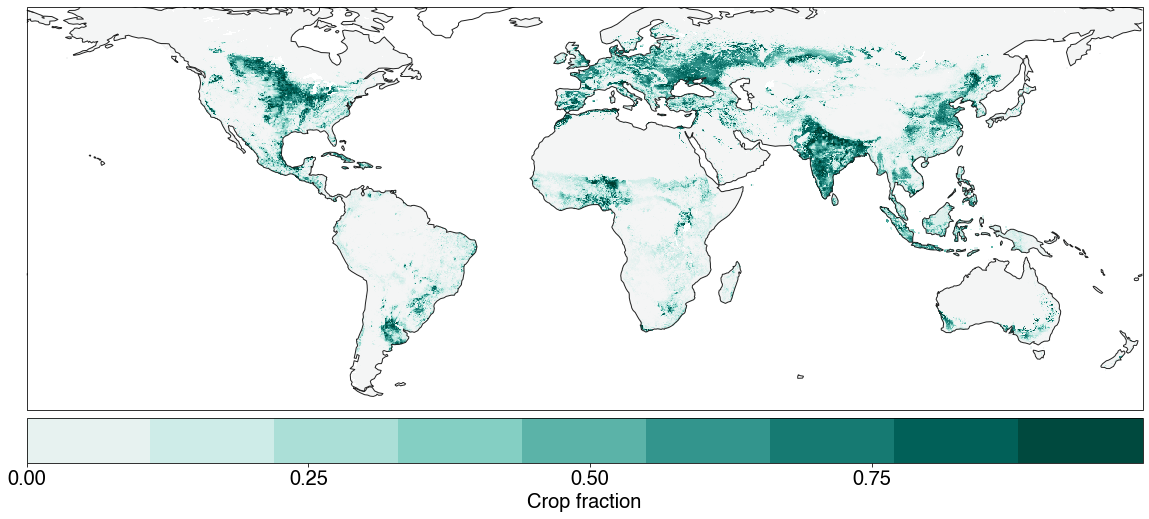

In [14]:
plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = 1
vstep = .11
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = crop_ha_regrid

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

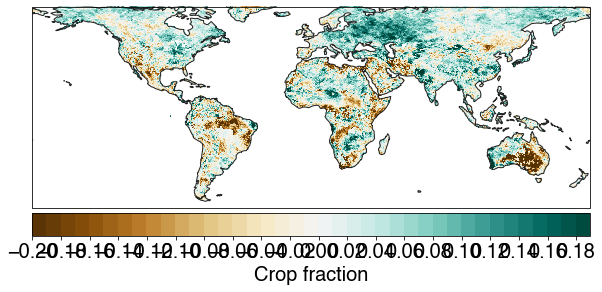

In [27]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.2
v2 = .2
vstep = .01
vlabelstep = .02

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

# data = np.nanmean(et_during_tx[-1,-20:,:,:],axis=0) - np.nanmean(et_during_tx[-1,0:20,:,:],axis=0)

data = et_on_txx_chg_81*.01
c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

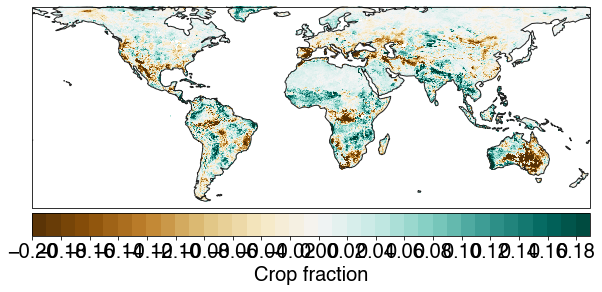

In [28]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.2
v2 = .2
vstep = .01
vlabelstep = .02

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = 

# data = et_on_txx_chg_81*.01
c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [40]:
rebuild = False

if rebuild:
    
    
    crop_ha_regrid_shift = crop_ha_regrid.copy()
    crop_ha_regrid_shift_up = crop_ha_regrid.copy()
    crop_ha_regrid_below = crop_ha_regrid.copy()
    crop_ha_regrid_above = crop_ha_regrid.copy()

    maize_chg_shift = maize_chg.copy()
    maize_chg_shift_up = maize_chg.copy()
    maize_chg_below = maize_chg.copy()
    maize_chg_above = maize_chg.copy()


    for x in range(crop_ha_regrid.shape[0]):
        if x%10 == 0: print(x)
        for y in range(crop_ha_regrid.shape[1]):
            if not (ds_grow_r_t_et_total_evap_01_21.r_t_et.values[x,y] < 0 and ds_grow_r_t_et_total_evap_81_01.r_t_et.values[x,y] > 0):
                crop_ha_regrid_shift[x,y]=np.nan
                
            if not (ds_grow_r_t_et_total_evap_01_21.r_t_et.values[x,y] > 0 and ds_grow_r_t_et_total_evap_81_01.r_t_et.values[x,y] < 0):
                crop_ha_regrid_shift_up[x,y]=np.nan

            if not (ds_grow_r_t_et_total_evap_01_21.r_t_et.values[x,y] < 0 and ds_grow_r_t_et_total_evap_81_01.r_t_et.values[x,y] < 0):
                crop_ha_regrid_below[x,y]=np.nan

            if not (ds_grow_r_t_et_total_evap_01_21.r_t_et.values[x,y] > 0 and ds_grow_r_t_et_total_evap_81_01.r_t_et.values[x,y] > 0):
                crop_ha_regrid_above[x,y]=np.nan


                
    with open('crop_rt_below_1981-2000_2001-2021-detrend.dat', 'wb') as f:
        pickle.dump(crop_ha_regrid_below, f)
    with open('crop_rt_above_1981-2000_2001-2021-detrend.dat', 'wb') as f:
            pickle.dump(crop_ha_regrid_above, f)
    with open('crop_rt_shift_1981-2000_2001-2021-detrend.dat', 'wb') as f:
            pickle.dump(crop_ha_regrid_shift, f)
    with open('crop_rt_shift_up_1981-2000_2001-2021-detrend.dat', 'wb') as f:
            pickle.dump(crop_ha_regrid_shift_up, f)
else:

    yr = '1961-1980_1981-2000'
    with open('crop_rt_below_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_below_61 = pickle.load(f)
    with open('crop_rt_above_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_above_61 = pickle.load(f)
    with open('crop_rt_shift_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_shift_61 = pickle.load(f)
    with open('crop_rt_shift_up_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_shift_up_61 = pickle.load(f)
        
    yr = '1971-1990_1991-2010'
    with open('crop_rt_below_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_below_71 = pickle.load(f)
    with open('crop_rt_above_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_above_71 = pickle.load(f)
    with open('crop_rt_shift_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_shift_71 = pickle.load(f)
    with open('crop_rt_shift_up_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_shift_up_71 = pickle.load(f)
        
    yr = '1981-2000_2001-2021'
    with open('crop_rt_below_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_below_81 = pickle.load(f)
    with open('crop_rt_above_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_above_81 = pickle.load(f)
    with open('crop_rt_shift_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_shift_81 = pickle.load(f)
    with open('crop_rt_shift_up_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_shift_up_81 = pickle.load(f)
        
#     yr = '1961-1990_1991-2021'
#     with open('crop_rt_below_%s-detrend.dat'%yr, 'rb') as f:
#         crop_ha_regrid_below_30y_61 = pickle.load(f)
#     with open('crop_rt_above_%s-detrend.dat'%yr, 'rb') as f:
#         crop_ha_regrid_above_30y_61 = pickle.load(f)
#     with open('crop_rt_shift_%s-detrend.dat'%yr, 'rb') as f:
#         crop_ha_regrid_shift_30y_61 = pickle.load(f)
#     with open('crop_rt_shift_up_%s-detrend.dat'%yr, 'rb') as f:
#         crop_ha_regrid_shift_up_30y_61 = pickle.load(f)

In [41]:
# n_total = np.where((~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_61_91.r_t_et.values)))[0].size

# shift_pct_30y_61 = np.where((~np.isnan(crop_ha_regrid_shift_30y_61)) & \
#                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_61_91.r_t_et.values)))[0].size/n_total
# shift_up_pct_30y_61 = np.where((~np.isnan(crop_ha_regrid_shift_up_30y_61)) & \
#                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_61_91.r_t_et.values)))[0].size/n_total

In [42]:
n_total = np.where((~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size

shift_pct_61 = np.where((~np.isnan(crop_ha_regrid_shift_61)) & \
                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total
shift_pct_71 = np.where((~np.isnan(crop_ha_regrid_shift_71)) & \
                       (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total
shift_pct_81 = np.where((~np.isnan(crop_ha_regrid_shift_81)) & \
                       (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total

shift_pct_up_61 = np.where((~np.isnan(crop_ha_regrid_shift_up_61)) & \
                          (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total
shift_pct_up_71 = np.where((~np.isnan(crop_ha_regrid_shift_up_71)) & \
                           (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total
shift_pct_up_81 = np.where((~np.isnan(crop_ha_regrid_shift_up_81)) & \
                           (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total

below_pct_61 = np.where((~np.isnan(crop_ha_regrid_below_61)) & \
                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total
below_pct_71 = np.where((~np.isnan(crop_ha_regrid_below_71)) & \
                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total
below_pct_81 = np.where((~np.isnan(crop_ha_regrid_below_81)) & \
                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total

above_pct_61 = np.where((~np.isnan(crop_ha_regrid_above_61)) & \
                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total
above_pct_71 = np.where((~np.isnan(crop_ha_regrid_above_71)) & \
                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total
above_pct_81 = np.where((~np.isnan(crop_ha_regrid_above_81)) & \
                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total

In [43]:
c_above = '#2db566'
c_below = '#3195e0'
c_shift = '#f03c4e'
c_shift_up = '#dd64ed'

Text(0, 0.5, 'fraction of gridcells')

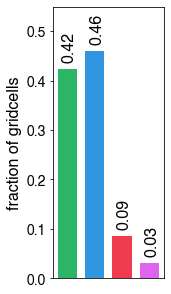

In [44]:
plt.figure(figsize=(2,5))
plt.ylim([0, .55])
plt.bar([1,2,3,4],[above_pct_81, below_pct_81, shift_pct_81, shift_pct_up_81], width=0.7, color=[c_above, c_below, c_shift, c_shift_up])
plt.text(4-.2, shift_pct_up_81+.02, '%.2f'%np.round(shift_pct_up_81,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(3-.2, shift_pct_81+.02, '%.2f'%np.round(shift_pct_81,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(2-.2, below_pct_81+.02, '%.2f'%np.round(below_pct_81,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(1-.2, above_pct_81+.02, '%.2f'%np.round(above_pct_81,2), fontsize=16, fontfamily='helvetica', rotation=90)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('fraction of gridcells')

# plt.savefig('t-et-81-conversion.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

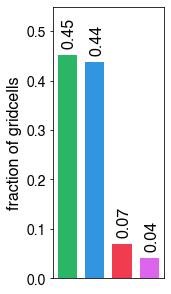

In [34]:
plt.figure(figsize=(2,5))
plt.ylim([0, .55])
plt.bar([1,2,3,4],[above_pct_71, below_pct_71, shift_pct_71, shift_pct_up_71], width=0.7, color=[c_above, c_below, c_shift, c_shift_up])
plt.text(4-.2, shift_pct_up_71+.02, '%.2f'%np.round(shift_pct_up_71,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(3-.2, shift_pct_71+.02, '%.2f'%np.round(shift_pct_71,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(2-.2, below_pct_71+.02, '%.2f'%np.round(below_pct_71,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(1-.2, above_pct_71+.02, '%.2f'%np.round(above_pct_71,2), fontsize=16, fontfamily='helvetica', rotation=90)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('fraction of gridcells')

plt.savefig('t-et-71-conversion.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

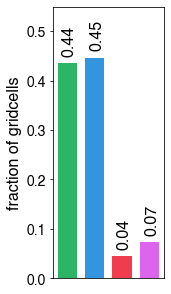

In [35]:
plt.figure(figsize=(2,5))
plt.ylim([0, .55])
plt.bar([1,2,3,4],[above_pct_61, below_pct_61, shift_pct_61, shift_pct_up_61], width=0.7, color=[c_above, c_below, c_shift, c_shift_up])
plt.text(4-.2, shift_pct_up_61+.02, '%.2f'%np.round(shift_pct_up_61,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(3-.2, shift_pct_61+.02, '%.2f'%np.round(shift_pct_61,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(2-.2, below_pct_61+.02, '%.2f'%np.round(below_pct_61,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(1-.2, above_pct_61+.02, '%.2f'%np.round(above_pct_61,2), fontsize=16, fontfamily='helvetica', rotation=90)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('fraction of gridcells')

plt.savefig('t-et-61-conversion.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

NameError: name 'crop_ha_regrid_above_30y_61' is not defined

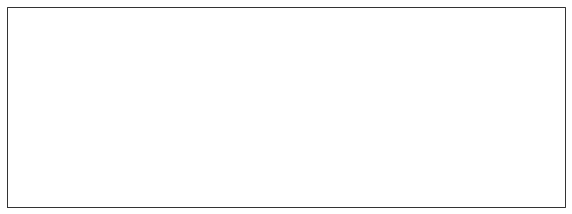

In [36]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-130, 160, 60, -60])

v1 = 0
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Greens')

data = crop_ha_regrid_above_30y_61

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Blues')

data = crop_ha_regrid_below_30y_61

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

data = crop_ha_regrid_shift_30y_61

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

plt.savefig('t-et-era5-map-30y-61.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-130, 160, 60, -60])

v1 = 0
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Greens')

data = crop_ha_regrid_above_61

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Blues')

data = crop_ha_regrid_below_61

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

data = crop_ha_regrid_shift_61

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

plt.savefig('t-et-era5-map-61.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-130, 160, 60, -60])

v1 = 0
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Greens')

data = crop_ha_regrid_above_71

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Blues')

data = crop_ha_regrid_below_71

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

data = crop_ha_regrid_shift_71

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

plt.savefig('t-et-era5-map-71.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-130, 160, 60, -60])

v1 = 0
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Greens')

data = crop_ha_regrid_above_81

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Blues')

data = crop_ha_regrid_below_81

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

data = crop_ha_regrid_shift_81

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

plt.savefig('t-et-era5-map-81.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-130, 160, 60, -60])

v1 = -.1
v2 = .1
vstep = .01
vlabelstep = .025

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Greens')

data = crop_ha_regrid_above-crop_ha_regrid_above_81

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Blues')

data = crop_ha_regrid_below - crop_ha_regrid_below_81

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

data = crop_ha_regrid_shift-crop_ha_regrid_shift_81

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

# plt.savefig('t-et-era5-map-81.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = ds_grow_r_t_et_total_evap_61_21.r_t_et.values

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season r(T, ET), 1961 - 2021', fontsize=20)

# plt.savefig('growing-season-r-t-et-map-61-21.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

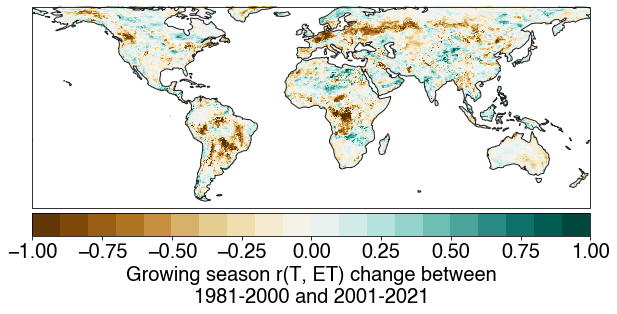

In [105]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = ds_grow_r_t_et_total_evap_01_21.r_t_et.values-ds_grow_r_t_et_total_evap_81_01.r_t_et.values

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season r(T, ET) change between\n1981-2000 and 2001-2021', fontsize=20)

# plt.savefig('growing-season-r-t-et-chg-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [112]:
np.where((data>0) & (crop_ha_regrid>0))[0].size/np.where((~np.isnan(data)) & (crop_ha_regrid>0))[0].size

0.38700022742779167

In [110]:
np.where((data<0) & (crop_ha_regrid>0))[0].size/np.where((~np.isnan(data)) & (crop_ha_regrid>0))[0].size

0.6129997725722083

In [578]:
lat_global_ind = np.arange(lat.size)
lat_global_no_ice_ind = np.where((lat>=-65) & (lat<=60))[0]
lat_nontropics_ind = np.where(((lat>=30) | (lat<=-30)) & (lat<=65) & (lat>=-65))[0]
lat_nh_ind = np.where((lat>=30) & (lat<=65))[0]
lat_tropics_ind = np.where((lat<30) & (lat>-30))[0]
lat_sh_ind = np.where((lat <= -30) & (lat >= -60))[0]

In [579]:
lat_ind_sel = lat_global_no_ice_ind

time_split = 20

# determine array size
num_elements = np.nanmean(tx_during_tw[0,:,:,:], axis=0)
num_elements = num_elements[lat_ind_sel,:].size

tx_during_tw_sel_1d = np.full([percentiles.size, num_elements], np.nan)

tx_during_tx_sel_1d = np.full([percentiles.size, num_elements], np.nan)
tx_during_tx_sel_1_1d = np.full([percentiles.size, num_elements], np.nan)
tx_during_tx_sel_2_1d = np.full([percentiles.size, num_elements], np.nan)

tw_during_tx_sel_1d = np.full([percentiles.size, num_elements], np.nan)
tw_during_tx_sel_1_1d = np.full([percentiles.size, num_elements], np.nan)
tw_during_tx_sel_2_1d = np.full([percentiles.size, num_elements], np.nan)

et_during_tx_sel_1d = np.full([percentiles.size, num_elements], np.nan)
et_during_tx_sel_1_1d = np.full([percentiles.size, num_elements], np.nan)
et_during_tx_sel_2_1d = np.full([percentiles.size, num_elements], np.nan)

sm_during_tx_sel_1d = np.full([percentiles.size, num_elements], np.nan)
sm_during_tx_sel_1_1d = np.full([percentiles.size, num_elements], np.nan)
sm_during_tx_sel_2_1d = np.full([percentiles.size, num_elements], np.nan)

tw_during_tw_sel_1d = np.full([percentiles.size, num_elements], np.nan)
tw_during_tw_sel_1_1d = np.full([percentiles.size, num_elements], np.nan)
tw_during_tw_sel_2_1d = np.full([percentiles.size, num_elements], np.nan)

for p in range(percentiles.size):
    
    t = np.nanmean(tx_during_tw[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tx_during_tw_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tx_during_tx[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tx_during_tx_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tx_during_tx[p, 0:time_split, :, :], axis=0)
    t = t[lat_ind_sel, :]
    tx_during_tx_sel_1_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tx_during_tx[p, time_split:, :, :], axis=0)
    t = t[lat_ind_sel, :]
    tx_during_tx_sel_2_1d[p, :] = t.reshape([t.size])
    
    
    
    t = np.nanmean(et_during_tx[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    et_during_tx_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(et_during_tx[p, 0:time_split, :, :], axis=0)
    t = t[lat_ind_sel, :]
    et_during_tx_sel_1_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(et_during_tx[p, time_split:, :, :], axis=0)
    t = t[lat_ind_sel, :]
    et_during_tx_sel_2_1d[p, :] = t.reshape([t.size])
    
    
    
    t = np.nanmean(sm_during_tx[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    sm_during_tx_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(sm_during_tx[p, 0:time_split, :, :], axis=0)
    t = t[lat_ind_sel, :]
    sm_during_tx_sel_1_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(sm_during_tx[p, time_split:, :, :], axis=0)
    t = t[lat_ind_sel, :]
    sm_during_tx_sel_2_1d[p, :] = t.reshape([t.size])
    
    
    
    t = np.nanmean(tw_during_tx[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tw_during_tx_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tw_during_tx[p, 0:time_split, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tw_during_tx_sel_1_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tw_during_tx[p, time_split:, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tw_during_tx_sel_2_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tw_during_tw[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tw_during_tw_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tw_during_tw[p, 0:time_split, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tw_during_tw_sel_1_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tw_during_tw[p, time_split:, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tw_during_tw_sel_2_1d[p, :] = t.reshape([t.size])

In [580]:

tmean_chg_81_sel = tmean_chg_81[lat_ind_sel,:]
tmean_chg_81_sel_1d = tmean_chg_81_sel.reshape([tmean_chg_81_sel.size, 1])

txx_chg_81_sel = txx_chg_81[lat_ind_sel,:]
txx_chg_81_sel_1d = txx_chg_81_sel.reshape([txx_chg_81_sel.size, 1])

sm_on_txx_chg_81_sel = sm_on_txx_chg_81[lat_ind_sel,:]
sm_on_txx_chg_81_sel_1d = sm_on_txx_chg_81_sel.reshape([sm_on_txx_chg_81_sel.size, 1])

et_on_txx_chg_81_sel = et_on_txx_chg_81[lat_ind_sel,:]
et_on_txx_chg_81_sel_1d = et_on_txx_chg_81_sel.reshape([et_on_txx_chg_81_sel.size, 1])


et_during_tw_sel = np.nanmean(et_during_tw, axis=0)
et_during_tw_sel = et_during_tw_sel[lat_ind_sel,:]
et_during_tw_sel_1d = et_during_tw_sel.reshape([et_during_tw_sel.size, 1])

# et_during_tx_sel = np.nanmean(et_during_tx, axis=0)
# et_during_tx_sel = et_during_tx_sel[lat_ind_sel,:]
# et_during_tx_sel_1d = et_during_tx_sel.reshape([et_during_tx_sel.size, 1])

# et_during_tx_1_sel = np.nanmean(et_during_tx[0:20,:,:], axis=0)
# et_during_tx_1_sel = et_during_tx_1_sel[lat_ind_sel,:]
# et_during_tx_1_sel_1d = et_during_tx_1_sel.reshape([et_during_tx_1_sel.size, 1])

# et_during_tx_2_sel = np.nanmean(et_during_tx[20:,:,:], axis=0)
# et_during_tx_2_sel = et_during_tx_2_sel[lat_ind_sel,:]
# et_during_tx_2_sel_1d = et_during_tx_2_sel.reshape([et_during_tx_2_sel.size, 1])

# huss_during_tx_sel = np.nanmean(huss_during_tx, axis=0)
# huss_during_tx_sel = huss_during_tx_sel[lat_ind_sel,:]
# huss_during_tx_sel_1d = huss_during_tx_sel.reshape([huss_during_tx_sel.size, 1])

huss_during_tx_1_sel = np.nanmean(huss_during_tx[0:time_split,:,:], axis=0)
huss_during_tx_1_sel = huss_during_tx_1_sel[lat_ind_sel,:]
huss_during_tx_1_sel_1d = huss_during_tx_1_sel.reshape([huss_during_tx_1_sel.size, 1])

huss_during_tx_2_sel = np.nanmean(huss_during_tx[time_split:,:,:], axis=0)
huss_during_tx_2_sel = huss_during_tx_2_sel[lat_ind_sel,:]
huss_during_tx_2_sel_1d = huss_during_tx_2_sel.reshape([huss_during_tx_2_sel.size, 1])

# sm_during_tx_1_sel = np.nanmean(sm_during_tx[0:20,:,:], axis=0)
# sm_during_tx_1_sel = sm_during_tx_1_sel[lat_ind_sel,:]
# sm_during_tx_1_sel_1d = sm_during_tx_1_sel.reshape([sm_during_tx_1_sel.size, 1])

# sm_during_tx_2_sel = np.nanmean(sm_during_tx[20:,:,:], axis=0)
# sm_during_tx_2_sel = sm_during_tx_2_sel[lat_ind_sel,:]
# sm_during_tx_2_sel_1d = sm_during_tx_2_sel.reshape([sm_during_tx_2_sel.size, 1])

# txx_amp_81_sel = txx_amp_81[lat_ind_sel,:]
# txx_amp_81_sel_1d = txx_amp_81_sel.reshape([txx_amp_81_sel.size,1])

# txx_amp_71_sel = txx_amp_71[lat_ind_sel,:]
# txx_amp_71_sel_1d = txx_amp_71_sel.reshape([txx_amp_71_sel.size,1])

# txx_amp_61_sel = txx_amp_61[lat_ind_sel,:]
# txx_amp_61_sel_1d = txx_amp_61_sel.reshape([txx_amp_61_sel.size,1])

huss_during_tw_sel = np.nanmean(huss_during_tw, axis=0)
huss_during_tw_sel = huss_during_tw_sel[lat_ind_sel,:]
huss_during_tw_sel_1d = huss_during_tw_sel.reshape([huss_during_tw_sel.size, 1])

et_during_tw_trend_sel = et_during_tw_trend[lat_ind_sel, :]*10
et_during_tw_trend_zonal_sel = (et_during_tw_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(et_during_tw_trend[lat_ind_sel, :],  axis=1), et_during_tw_trend.shape[1], 1).T)*10
et_during_tw_trend_sel_1d = np.reshape(et_during_tw_trend_sel, [et_during_tw_trend_sel.size, 1])
et_during_tw_trend_zonal_sel_1d = np.reshape(et_during_tw_trend_zonal_sel, [et_during_tw_trend_zonal_sel.size, 1])

huss_during_tw_trend_sel = huss_during_tw_trend[lat_ind_sel, :]*10
huss_during_tw_trend_zonal_sel = (huss_during_tw_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(huss_during_tw_trend[lat_ind_sel, :],  axis=1), huss_during_tw_trend.shape[1], 1).T)*10
huss_during_tw_trend_sel_1d = np.reshape(huss_during_tw_trend_sel, [huss_during_tw_trend_sel.size, 1])
huss_during_tw_trend_zonal_sel_1d = np.reshape(huss_during_tw_trend_zonal_sel, [huss_during_tw_trend_zonal_sel.size, 1])

tw_during_tw_trend_sel = tw_during_tw_trend[lat_ind_sel, :]*10
tw_during_tw_trend_zonal_sel = (tw_during_tw_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(tw_during_tw_trend[lat_ind_sel, :],  axis=1), tw_during_tw_trend.shape[1], 1).T)*10
tw_during_tw_trend_sel_1d = np.reshape(tw_during_tw_trend_sel, [tw_during_tw_trend_sel.size, 1])
tw_during_tw_trend_zonal_sel_1d = np.reshape(tw_during_tw_trend_zonal_sel, [tw_during_tw_trend_zonal_sel.size, 1])

tx_during_tw_trend_sel = tx_during_tw_trend[lat_ind_sel, :]*10
tx_during_tw_trend_zonal_sel = (tx_during_tw_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(tx_during_tw_trend[lat_ind_sel, :],  axis=1), tx_during_tw_trend.shape[1], 1).T)*10
tx_during_tw_trend_sel_1d = np.reshape(tx_during_tw_trend_sel, [tx_during_tw_trend_sel.size, 1])
tx_during_tw_trend_zonal_sel_1d = np.reshape(tx_during_tw_trend_zonal_sel, [tx_during_tw_trend_zonal_sel.size, 1])

et_during_tx_trend_sel = et_during_tx_trend[lat_ind_sel, :]*10
et_during_tx_trend_zonal_sel = (et_during_tx_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(et_during_tx_trend[lat_ind_sel, :],  axis=1), et_during_tx_trend.shape[1], 1).T)*10
et_during_tx_trend_sel_1d = np.reshape(et_during_tx_trend_sel, [et_during_tx_trend_sel.size, 1])
et_during_tx_trend_zonal_sel_1d = np.reshape(et_during_tx_trend_zonal_sel, [et_during_tx_trend_zonal_sel.size, 1])

huss_during_tx_trend_sel = huss_during_tx_trend[lat_ind_sel, :]*10
huss_during_tx_trend_zonal_sel = (huss_during_tx_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(huss_during_tx_trend[lat_ind_sel, :],  axis=1), huss_during_tx_trend.shape[1], 1).T)*10
huss_during_tx_trend_sel_1d = np.reshape(huss_during_tx_trend_sel, [huss_during_tx_trend_sel.size, 1])
huss_during_tx_trend_zonal_sel_1d = np.reshape(huss_during_tx_trend_zonal_sel, [huss_during_tx_trend_zonal_sel.size, 1])

tw_during_tx_trend_sel = tw_during_tx_trend[lat_ind_sel, :]*10
tw_during_tx_trend_zonal_sel = (tw_during_tx_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(tw_during_tx_trend[lat_ind_sel, :],  axis=1), tw_during_tx_trend.shape[1], 1).T)*10
tw_during_tx_trend_sel_1d = np.reshape(tw_during_tx_trend_sel, [tw_during_tx_trend_sel.size, 1])
tw_during_tx_trend_zonal_sel_1d = np.reshape(tw_during_tx_trend_zonal_sel, [tw_during_tx_trend_zonal_sel.size, 1])

tx_during_tx_trend_sel = tx_during_tx_trend[lat_ind_sel, :]*10
tx_during_tx_trend_zonal_sel = (tx_during_tx_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(tx_during_tx_trend[lat_ind_sel, :],  axis=1), tx_during_tx_trend.shape[1], 1).T)*10
tx_during_tx_trend_sel_1d = np.reshape(tx_during_tx_trend_sel, [tx_during_tx_trend_sel.size, 1])
tx_during_tx_trend_zonal_sel_1d = np.reshape(tx_during_tx_trend_zonal_sel, [tx_during_tx_trend_zonal_sel.size, 1])



t_et_81_16 = ds_grow_r_t_et_total_evap_81_16.r_t_et.values
t_et_81_16 = t_et_81_16[lat_ind_sel,:]
t_et_81_16_1d = t_et_81_16.reshape([t_et_81_16.size, 1])

t_et_81_16_soy = ds_grow_r_t_et_total_evap_81_16_soy.r_t_et.values
t_et_81_16_soy = t_et_81_16_soy[lat_ind_sel,:]
t_et_81_16_soy_1d = t_et_81_16_soy.reshape([t_et_81_16_soy.size, 1])


t_et_81_16_wheat = ds_grow_r_t_et_total_evap_81_16_wheat.r_t_et.values
t_et_81_16_wheat = t_et_81_16_wheat[lat_ind_sel,:]
t_et_81_16_wheat_1d = t_et_81_16_wheat.reshape([t_et_81_16_wheat.size, 1])


t_et_61_81 = ds_grow_r_t_et_total_evap_61_81.r_t_et.values
t_et_61_81 = t_et_61_81[lat_ind_sel,:]
t_et_61_81_1d = t_et_61_81.reshape([t_et_61_81.size, 1])

t_et_61_21 = ds_grow_r_t_et_total_evap_61_21.r_t_et.values
t_et_61_21 = t_et_61_21[lat_ind_sel,:]
t_et_61_21_1d = t_et_61_21.reshape([t_et_61_21.size, 1])

t_et_71_91 = ds_grow_r_t_et_total_evap_71_91.r_t_et.values
t_et_71_91 = t_et_71_91[lat_ind_sel,:]
t_et_71_91_1d = t_et_71_91.reshape([t_et_71_91.size, 1])

t_et_81_01 = ds_grow_r_t_et_total_evap_81_01.r_t_et.values
t_et_81_01 = t_et_81_01[lat_ind_sel,:]
t_et_81_01_1d = t_et_81_01.reshape([t_et_81_01.size, 1])

t_et_81_01_soy = ds_grow_r_t_et_total_evap_81_01_soy.r_t_et.values
t_et_81_01_soy = t_et_81_01_soy[lat_ind_sel,:]
t_et_81_01_soy_1d = t_et_81_01_soy.reshape([t_et_81_01_soy.size, 1])

t_et_81_01_wheat = ds_grow_r_t_et_total_evap_81_01_wheat.r_t_et.values
t_et_81_01_wheat = t_et_81_01_wheat[lat_ind_sel,:]
t_et_81_01_wheat_1d = t_et_81_01_wheat.reshape([t_et_81_01_wheat.size, 1])

t_et_91_11 = ds_grow_r_t_et_total_evap_91_11.r_t_et.values
t_et_91_11 = t_et_91_11[lat_ind_sel,:]
t_et_91_11_1d = t_et_91_11.reshape([t_et_91_11.size, 1])

t_et_01_21 = ds_grow_r_t_et_total_evap_01_21.r_t_et.values
t_et_01_21 = t_et_01_21[lat_ind_sel,:]
t_et_01_21_1d = t_et_01_21.reshape([t_et_01_21.size, 1])

t_et_01_21_soy = ds_grow_r_t_et_total_evap_01_21_soy.r_t_et.values
t_et_01_21_soy = t_et_01_21_soy[lat_ind_sel,:]
t_et_01_21_soy_1d = t_et_01_21_soy.reshape([t_et_01_21_soy.size, 1])

t_et_01_21_wheat = ds_grow_r_t_et_total_evap_01_21_wheat.r_t_et.values
t_et_01_21_wheat = t_et_01_21_wheat[lat_ind_sel,:]
t_et_01_21_wheat_1d = t_et_01_21_wheat.reshape([t_et_01_21_wheat.size, 1])

sacksStart_regrid_sel = sacksStart_regrid[lat_ind_sel,:]
sacksStart_regrid_sel_1d = sacksStart_regrid_sel.reshape([sacksStart_regrid_sel.size, 1])

sacksEnd_regrid_sel = sacksEnd_regrid[lat_ind_sel,:]
sacksEnd_regrid_sel_1d = sacksEnd_regrid_sel.reshape([sacksEnd_regrid_sel.size, 1])

crop_ha_regrid_sel = crop_ha_regrid[lat_ind_sel,:]
crop_ha_regrid_sel_1d = crop_ha_regrid_sel.reshape([crop_ha_regrid_sel.size, 1])

ind = np.where((np.isnan(crop_ha_regrid_sel_1d)) & (~np.isnan(t_et_01_21_1d)))[0]
crop_ha_regrid_sel_1d[ind] = 0


maize_ha_regrid_sel_chg = maize_ha_regrid_2005[lat_ind_sel,:]-maize_ha_regrid_1995[lat_ind_sel,:]
maize_ha_regrid_sel_chg_1d = maize_ha_regrid_sel_chg.reshape([maize_ha_regrid_sel_chg.size, 1])

soy_ha_regrid_sel_chg = soy_ha_regrid_2005[lat_ind_sel,:]-soy_ha_regrid_1995[lat_ind_sel,:]
soy_ha_regrid_sel_chg_1d = soy_ha_regrid_sel_chg.reshape([soy_ha_regrid_sel_chg.size, 1])

wheat_ha_regrid_sel_chg = wheat_ha_regrid_2005[lat_ind_sel,:]-wheat_ha_regrid_1995[lat_ind_sel,:]
wheat_ha_regrid_sel_chg_1d = wheat_ha_regrid_sel_chg.reshape([wheat_ha_regrid_sel_chg.size, 1])



irrigationData_regrid_sel = irrigationData_regrid[lat_ind_sel, :]
irrigationData_regrid_sel_1d = irrigationData_regrid_sel.reshape([irrigationData_regrid_sel.size, 1])

iizumi_maize_ds_regrid_values = iizumi_maize_ds_regrid['var'].values
iizumi_maize_ds_regrid_values[iizumi_maize_ds_regrid_values==0] = np.nan
iizumi_maize_ds_regrid_values = iizumi_maize_ds_regrid_values[:,lat_ind_sel,:]
iizumi_maize_ds_regrid_values_1 = np.nanmean(iizumi_maize_ds_regrid_values[0:time_split, :, :], axis=0)
iizumi_maize_ds_regrid_values_1_1d = np.reshape(iizumi_maize_ds_regrid_values_1, [iizumi_maize_ds_regrid_values_1.size, 1])
iizumi_maize_ds_regrid_values_2 = np.nanmean(iizumi_maize_ds_regrid_values[time_split:, :, :], axis=0)
iizumi_maize_ds_regrid_values_2_1d = np.reshape(iizumi_maize_ds_regrid_values_2, [iizumi_maize_ds_regrid_values_2.size, 1])



iizumi_soy_ds_regrid_values = iizumi_soy_ds_regrid['var'].values
iizumi_soy_ds_regrid_values[iizumi_soy_ds_regrid_values==0] = np.nan
iizumi_soy_ds_regrid_values = iizumi_soy_ds_regrid_values[:, lat_ind_sel, :]
iizumi_soy_ds_regrid_values_1 = np.nanmean(iizumi_soy_ds_regrid_values[0:time_split, :, :], axis=0)
iizumi_soy_ds_regrid_values_1_1d = np.reshape(iizumi_soy_ds_regrid_values_1, [iizumi_soy_ds_regrid_values_1.size, 1])
iizumi_soy_ds_regrid_values_2 = np.nanmean(iizumi_soy_ds_regrid_values[time_split:, :, :], axis=0)
iizumi_soy_ds_regrid_values_2_1d = np.reshape(iizumi_soy_ds_regrid_values_2, [iizumi_soy_ds_regrid_values_2.size, 1])

iizumi_wheat_ds_regrid_values = iizumi_wheat_ds_regrid['var'].values
iizumi_wheat_ds_regrid_values[iizumi_wheat_ds_regrid_values==0] = np.nan
iizumi_wheat_ds_regrid_values = iizumi_wheat_ds_regrid_values[:, lat_ind_sel, :]
iizumi_wheat_ds_regrid_values_1 = np.nanmean(iizumi_wheat_ds_regrid_values[0:time_split, :, :], axis=0)
iizumi_wheat_ds_regrid_values_1_1d = np.reshape(iizumi_wheat_ds_regrid_values_1, [iizumi_wheat_ds_regrid_values_1.size, 1])
iizumi_wheat_ds_regrid_values_2 = np.nanmean(iizumi_wheat_ds_regrid_values[time_split:, :, :], axis=0)
iizumi_wheat_ds_regrid_values_2_1d = np.reshape(iizumi_wheat_ds_regrid_values_2, [iizumi_wheat_ds_regrid_values_2.size, 1])


In [581]:
# nn = np.where((~np.isnan(tx_during_tw_trend_sel_1d)) & (irrigationData_regrid_sel_1d/100 > 0.2*crop_ha_regrid_sel_1d))[0]
# nn = np.where((~np.isnan(tx_during_tx_sel_1d[0,:].reshape([tx_during_tx_sel_1d[0,:].size,1]))) & \
#               (~np.isnan(et_during_tx_sel_1d[0,:].reshape([et_during_tx_sel_1d[0,:].size,1]))) & \
#               (irrigationData_regrid_sel_1d/100 <= 0.01*crop_ha_regrid_sel_1d))[0]


nn = np.where((~np.isnan(tx_during_tx_sel_1d[0,:].reshape([tx_during_tx_sel_1d[0,:].size,1]))) & \
              (~np.isnan(et_during_tx_sel_1d[0,:].reshape([et_during_tx_sel_1d[0,:].size,1]))) & \
              (~np.isnan(crop_ha_regrid_sel_1d)) & (crop_ha_regrid_sel_1d>0))[0]

data = {
        'tx_during_tw_trend':tx_during_tw_trend_sel_1d[nn].reshape([nn.size]), \
        'et_during_tw_trend':et_during_tw_trend_sel_1d[nn].reshape([nn.size]), \
        'huss_during_tw_trend':huss_during_tw_trend_sel_1d[nn].reshape([nn.size]), \
        'tw_during_tw_trend':tw_during_tw_trend_sel_1d[nn].reshape([nn.size]), \
        'tx_during_tx_trend':tx_during_tx_trend_sel_1d[nn].reshape([nn.size]), \
        'et_during_tx_trend':et_during_tx_trend_sel_1d[nn].reshape([nn.size]), \
        'huss_during_tx_trend':huss_during_tx_trend_sel_1d[nn].reshape([nn.size]), \
        'tw_during_tx_trend':tw_during_tx_trend_sel_1d[nn].reshape([nn.size]), \
        
        'sacks_start':sacksStart_regrid_sel_1d[nn].reshape([nn.size]), \
        'sacks_end':sacksEnd_regrid_sel_1d[nn].reshape([nn.size]), \
    
        'tx_during_tx_trend_zonal':tx_during_tx_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'et_during_tx_trend_zonal':et_during_tx_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'huss_during_tx_trend_zonal':huss_during_tx_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'tw_during_tx_trend_zonal':tw_during_tx_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        
        'tx_during_tw_trend_zonal':tx_during_tw_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'et_during_tw_trend_zonal':et_during_tw_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'huss_during_tw_trend_zonal':huss_during_tw_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'tw_during_tw_trend_zonal':tw_during_tw_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        
#         'txx_amp_81':txx_amp_81_sel_1d[nn].reshape([nn.size]), \
#         'txx_amp_71':txx_amp_71_sel_1d[nn].reshape([nn.size]), \
#         'txx_amp_61':txx_amp_61_sel_1d[nn].reshape([nn.size]), \
        
        'tmean_chg_81_sel_1d':tmean_chg_81_sel_1d.reshape([tmean_chg_81_sel_1d.size])[nn], \
        'txx_chg_81_sel_1d':txx_chg_81_sel_1d.reshape([txx_chg_81_sel_1d.size])[nn], \
        'sm_on_txx_chg_81_sel_1d':sm_on_txx_chg_81_sel_1d.reshape([sm_on_txx_chg_81_sel_1d.size])[nn], \
        'et_on_txx_chg_81_sel_1d':et_on_txx_chg_81_sel_1d.reshape([et_on_txx_chg_81_sel_1d.size])[nn], \
    
        'tx_during_tx_99_1':tx_during_tx_sel_1_1d[np.where(percentiles==99)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_99_2':tx_during_tx_sel_2_1d[np.where(percentiles==99)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_98_1':tx_during_tx_sel_1_1d[np.where(percentiles==98)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_98_2':tx_during_tx_sel_2_1d[np.where(percentiles==98)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_97_1':tx_during_tx_sel_1_1d[np.where(percentiles==97)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_97_2':tx_during_tx_sel_2_1d[np.where(percentiles==97)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_96_1':tx_during_tx_sel_1_1d[np.where(percentiles==96)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_96_2':tx_during_tx_sel_2_1d[np.where(percentiles==96)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_95':tx_during_tx_sel_1d[np.where(percentiles==95)[0],:].reshape([tx_during_tx_sel_1d[0,:].size])[nn], \
        'tx_during_tx_95_1':tx_during_tx_sel_1_1d[np.where(percentiles==95)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_95_2':tx_during_tx_sel_2_1d[np.where(percentiles==95)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_90_1':tx_during_tx_sel_1_1d[np.where(percentiles==90)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_90_2':tx_during_tx_sel_2_1d[np.where(percentiles==90)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_80_1':tx_during_tx_sel_1_1d[np.where(percentiles==80)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_80_2':tx_during_tx_sel_2_1d[np.where(percentiles==80)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_50_1':tx_during_tx_sel_1_1d[np.where(percentiles==50)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_50_2':tx_during_tx_sel_2_1d[np.where(percentiles==50)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
    
    
        'tw_during_tx_99_1':tw_during_tx_sel_1_1d[np.where(percentiles==99)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_99_2':tw_during_tx_sel_2_1d[np.where(percentiles==99)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tx_98_1':tw_during_tx_sel_1_1d[np.where(percentiles==98)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_98_2':tw_during_tx_sel_2_1d[np.where(percentiles==98)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tx_97_1':tw_during_tx_sel_1_1d[np.where(percentiles==97)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_97_2':tw_during_tx_sel_2_1d[np.where(percentiles==97)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tx_96_1':tw_during_tx_sel_1_1d[np.where(percentiles==96)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_96_2':tw_during_tx_sel_2_1d[np.where(percentiles==96)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tx_95_1':tw_during_tx_sel_1_1d[np.where(percentiles==95)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_95_2':tw_during_tx_sel_2_1d[np.where(percentiles==95)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tx_90_1':tw_during_tx_sel_1_1d[np.where(percentiles==90)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_90_2':tw_during_tx_sel_2_1d[np.where(percentiles==90)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tx_80_1':tw_during_tx_sel_1_1d[np.where(percentiles==80)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_80_2':tw_during_tx_sel_2_1d[np.where(percentiles==80)[0],:].reshape([tw_during_tx_sel_1_1d[0,:].size])[nn], \

    
        'et_during_tx_99_1':et_during_tx_sel_1_1d[np.where(percentiles==99)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_99_2':et_during_tx_sel_2_1d[np.where(percentiles==99)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
      
        'et_during_tx_98_1':et_during_tx_sel_1_1d[np.where(percentiles==98)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_98_2':et_during_tx_sel_2_1d[np.where(percentiles==98)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_97_1':et_during_tx_sel_1_1d[np.where(percentiles==97)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_97_2':et_during_tx_sel_2_1d[np.where(percentiles==97)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_96_1':et_during_tx_sel_1_1d[np.where(percentiles==96)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_96_2':et_during_tx_sel_2_1d[np.where(percentiles==96)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_95_1':et_during_tx_sel_1_1d[np.where(percentiles==95)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_95_2':et_during_tx_sel_2_1d[np.where(percentiles==95)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_90_1':et_during_tx_sel_1_1d[np.where(percentiles==90)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_90_2':et_during_tx_sel_2_1d[np.where(percentiles==90)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_80_1':et_during_tx_sel_1_1d[np.where(percentiles==80)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_80_2':et_during_tx_sel_2_1d[np.where(percentiles==80)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_50_1':et_during_tx_sel_1_1d[np.where(percentiles==50)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_50_2':et_during_tx_sel_2_1d[np.where(percentiles==50)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'sm_during_tx_99_1':sm_during_tx_sel_1_1d[np.where(percentiles==99)[0],:].reshape([sm_during_tx_sel_1_1d[0,:].size])[nn], \
        'sm_during_tx_99_2':sm_during_tx_sel_2_1d[np.where(percentiles==99)[0],:].reshape([sm_during_tx_sel_2_1d[0,:].size])[nn], \
    
        'sm_during_tx_95_1':sm_during_tx_sel_1_1d[np.where(percentiles==95)[0],:].reshape([sm_during_tx_sel_1_1d[0,:].size])[nn], \
        'sm_during_tx_95_2':sm_during_tx_sel_2_1d[np.where(percentiles==95)[0],:].reshape([sm_during_tx_sel_2_1d[0,:].size])[nn], \
    
        'sm_during_tx_90_1':sm_during_tx_sel_1_1d[np.where(percentiles==90)[0],:].reshape([sm_during_tx_sel_1_1d[0,:].size])[nn], \
        'sm_during_tx_90_2':sm_during_tx_sel_2_1d[np.where(percentiles==90)[0],:].reshape([sm_during_tx_sel_2_1d[0,:].size])[nn], \
    
        
    
        'tw_during_tw_99_1':tw_during_tw_sel_1_1d[np.where(percentiles==99)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
        'tw_during_tw_99_2':tw_during_tw_sel_2_1d[np.where(percentiles==99)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tw_98_1':tw_during_tw_sel_1_1d[np.where(percentiles==98)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
        'tw_during_tw_98_2':tw_during_tw_sel_2_1d[np.where(percentiles==98)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tw_97_1':tw_during_tw_sel_1_1d[np.where(percentiles==97)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
        'tw_during_tw_97_2':tw_during_tw_sel_2_1d[np.where(percentiles==97)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tw_96_1':tw_during_tw_sel_1_1d[np.where(percentiles==96)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
        'tw_during_tw_96_2':tw_during_tw_sel_2_1d[np.where(percentiles==96)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tw_95_1':tw_during_tw_sel_1_1d[np.where(percentiles==95)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
        'tw_during_tw_95_2':tw_during_tw_sel_2_1d[np.where(percentiles==95)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tw_90_1':tw_during_tw_sel_1_1d[np.where(percentiles==90)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
        'tw_during_tw_90_2':tw_during_tw_sel_2_1d[np.where(percentiles==90)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
    
        'tw_during_tw_80_1':tw_during_tw_sel_1_1d[np.where(percentiles==80)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
        'tw_during_tw_80_2':tw_during_tw_sel_2_1d[np.where(percentiles==80)[0],:].reshape([tw_during_tw_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tw':et_during_tw_sel_1d[nn].reshape([nn.size]), \
        
        'huss_during_tx_1':huss_during_tx_1_sel_1d[nn].reshape([nn.size]), \
        'huss_during_tx_2':huss_during_tx_2_sel_1d[nn].reshape([nn.size]), \
        
        'maize_yield_1':iizumi_maize_ds_regrid_values_1_1d[nn].reshape([nn.size]), \
        'maize_yield_2':iizumi_maize_ds_regrid_values_2_1d[nn].reshape([nn.size]), \
    
        'soy_yield_1':iizumi_soy_ds_regrid_values_1_1d[nn].reshape([nn.size]), \
        'soy_yield_2':iizumi_soy_ds_regrid_values_2_1d[nn].reshape([nn.size]), \
    
        'wheat_yield_1':iizumi_wheat_ds_regrid_values_1_1d[nn].reshape([nn.size]), \
        'wheat_yield_2':iizumi_wheat_ds_regrid_values_2_1d[nn].reshape([nn.size]), \
        
        'huss_during_tw':huss_during_tw_sel_1d[nn].reshape([nn.size]), \
    
        'r_t_et_61_21':t_et_61_21_1d[nn].reshape([nn.size]), \
        'r_t_et_61_81':t_et_61_81_1d[nn].reshape([nn.size]), \
        'r_t_et_71_91':t_et_71_91_1d[nn].reshape([nn.size]), \
        'r_t_et_81_01':t_et_81_01_1d[nn].reshape([nn.size]), \
        'r_t_et_81_01_soy':t_et_81_01_soy_1d[nn].reshape([nn.size]), \
        'r_t_et_81_01_wheat':t_et_81_01_wheat_1d[nn].reshape([nn.size]), \
        'r_t_et_91_11':t_et_91_11_1d[nn].reshape([nn.size]), \
        'r_t_et_01_21':t_et_01_21_1d[nn].reshape([nn.size]), \
        'r_t_et_01_21_soy':t_et_01_21_soy_1d[nn].reshape([nn.size]), \
        'r_t_et_01_21_wheat':t_et_01_21_wheat_1d[nn].reshape([nn.size]), \
    
        'r_t_et_81_16':t_et_81_16_1d[nn].reshape([nn.size]), \
        'r_t_et_81_16_soy':t_et_81_16_soy_1d[nn].reshape([nn.size]), \
        'r_t_et_81_16_wheat':t_et_81_16_wheat_1d[nn].reshape([nn.size]), \
    
    
    
        'cf':crop_ha_regrid_sel_1d[nn].reshape([nn.size]),\
        'maize_ha_chg':maize_ha_regrid_sel_chg_1d[nn].reshape([nn.size]), \
        'soy_ha_chg':soy_ha_regrid_sel_chg_1d[nn].reshape([nn.size]), \
        'wheat_ha_chg':wheat_ha_regrid_sel_chg_1d[nn].reshape([nn.size])}


df = pd.DataFrame(data, \
                  columns=[
                            'tx_during_tw_trend', 'huss_during_tw_trend', 'et_during_tw_trend', 'tw_during_tw_trend', \
                           'tx_during_tx_trend', 'huss_during_tx_trend', 'et_during_tx_trend', 'tw_during_tx_trend', \
                           'tx_during_tx_trend_zonal', 'huss_during_tx_trend_zonal', 'et_during_tx_trend_zonal', 'tw_during_tx_trend_zonal', \
                           'tx_during_tw_trend_zonal', 'huss_during_tw_trend_zonal', 'et_during_tw_trend_zonal', 'tw_during_tw_trend_zonal', \
                           'et_during_tx', 'et_during_tw', 'huss_during_tx', 'huss_during_tw', \
                           'tx_during_tx', 'tx_during_tw', 'tw_during_tx', 'tw_during_tw', \
                           'tx_during_tx_1', 'tx_during_tx_2', 'tx_during_tx_diff', \
    
#                             'txx_amp_81', \
#                             'txx_amp_71', \
#                             'txx_amp_61', \
    
                            'txx_chg_81_sel_1d',\
                            'sm_on_txx_chg_81_sel_1d',\
                            'et_on_txx_chg_81_sel_1d',\
    
                           'tx_during_tx_99_1', 'tx_during_tx_99_2', \
                           'tx_during_tx_98_1', 'tx_during_tx_98_2', \
                           'tx_during_tx_97_1', 'tx_during_tx_97_2', \
                           'tx_during_tx_96_1', 'tx_during_tx_96_2', \
                           'tx_during_tx_95_1', 'tx_during_tx_95_2', \
                           'tx_during_tx_90_1', 'tx_during_tx_90_2', \
                           'tx_during_tx_80_1', 'tx_during_tx_80_2', \
                            'tx_during_tx_50_1', 'tx_during_tx_50_2', \
    
                            'tx_during_tx_95', \
    
                           'et_during_tx_99_1', 'et_during_tx_99_2', \
                            'et_during_tx_98_1', 'et_during_tx_98_2', \
                            'et_during_tx_97_1', 'et_during_tx_97_2', \
                            'et_during_tx_96_1', 'et_during_tx_96_2', \
                            'et_during_tx_95_1', 'et_during_tx_95_2', \
                            'et_during_tx_90_1', 'et_during_tx_90_2', \
                            'et_during_tx_80_1', 'et_during_tx_80_2', \
                            'et_during_tx_50_1', 'et_during_tx_50_2', \
    
                           'huss_during_tx_1', 'huss_during_tx_2', \
    
                           'sm_during_tx_99_1', 'sm_during_tx_99_2', \
                            'sm_during_tx_95_1', 'sm_during_tx_95_2', \
                            'sm_during_tx_90_1', 'sm_during_tx_90_2', \
    
                           'tw_during_tx_99_1', 'tw_during_tx_99_2', \
                           'tw_during_tx_98_1', 'tw_during_tx_98_2', \
                           'tw_during_tx_97_1', 'tw_during_tx_97_2', \
                           'tw_during_tx_96_1', 'tw_during_tx_96_2', \
                           'tw_during_tx_95_1', 'tw_during_tx_95_2', \
                           'tw_during_tx_90_1', 'tw_during_tx_90_2', \
                           'tw_during_tx_80_1', 'tw_during_tx_80_2', \
    
                            'tw_during_tw_99_1', 'tw_during_tw_99_2', \
                           'tw_during_tw_98_1', 'tw_during_tw_98_2', \
                           'tw_during_tw_97_1', 'tw_during_tw_97_2', \
                           'tw_during_tw_96_1', 'tw_during_tw_96_2', \
                           'tw_during_tw_95_1', 'tw_during_tw_95_2', \
                           'tw_during_tw_90_1', 'tw_during_tw_90_2', \
                           'tw_during_tw_80_1', 'tw_during_tw_80_2', \
                            'r_t_et_61_81', 
                            'r_t_et_71_91', 
                            'r_t_et_81_01', 'r_t_et_81_01_soy', 'r_t_et_81_01_wheat', 
                            'r_t_et_91_11', 
                            'r_t_et_01_21', 'r_t_et_01_21_soy', 'r_t_et_01_21_wheat', 
                            'r_t_et_81_16'
                            'r_t_et_81_16_soy',
                            'r_t_et_81_16_wheat',
                            'r_t_et_61_21', 
    
                            'cf', \
                            'maize_yield_1', 'maize_yield_2', \
                            'soy_yield_1', 'soy_yield_2', \
                            'wheat_yield_1', 'wheat_yield_2', \
                            'maize_ha_chg', 'soy_ha_chg', 'wheat_ha_chg'])


In [582]:
y1 = '81_01'
y2 = '01_21'

nn_shift = np.where((data['r_t_et_%s'%y1] > 0) & (data['r_t_et_%s'%y2] < 0))[0]
nn_shift_up = np.where((data['r_t_et_%s'%y1] < 0) & (data['r_t_et_%s'%y2] > 0))[0]
nn_above = np.where((data['r_t_et_%s'%y1] > 0) & (data['r_t_et_%s'%y2] > 0))[0]
nn_below = np.where((data['r_t_et_%s'%y1] < 0) & (data['r_t_et_%s'%y2] < 0))[0]

pct = 95

In [ ]:
nn_crop_heavy = np.where((data['cf']>0.25))[0]

plt.scatter(data['r_t_et_%s'%y1], data['r_t_et_%s'%y2], c=data['r_t_et_%s'%y2], cmap='bwr_r', vmin=-1, vmax=1)

plt.plot([np.nanmean(data['r_t_et_%s'%y1][nn_crop_heavy]), np.nanmean(data['r_t_et_%s'%y1][nn_crop_heavy])], [-1, 1], '--k')
plt.plot([np.nanmean(data['r_t_et_%s'%y2][nn_crop_heavy]), np.nanmean(data['r_t_et_%s'%y2][nn_crop_heavy])], [-1, 1], '--k')
         
plt.xlabel('1981 - 2000 r(T, ET)')
plt.ylabel('2000 - 2020 r(T, ET)')
plt.colorbar()

In [ ]:
nn_crop_heavy = np.where((data['cf']>0.25))[0]

plt.scatter(data['r_t_et_%s'%y1], data['r_t_et_%s'%y2]-data['r_t_et_%s'%y1], c=data['r_t_et_%s'%y2], cmap='BrBG', vmin=-1, vmax=1)

plt.plot([np.nanmean(data['r_t_et_%s'%y1][nn_crop_heavy]), np.nanmean(data['r_t_et_%s'%y1][nn_crop_heavy])], [-1, 1], '--k')
plt.plot([np.nanmean(data['r_t_et_%s'%y2][nn_crop_heavy]), np.nanmean(data['r_t_et_%s'%y2][nn_crop_heavy])], [-1, 1], '--k')
         
plt.xlabel('1981 - 2000 r(T, ET)')
plt.ylabel('Change in r(T, ET)\n(2000-2020 minus 1981-2000)')
cb = plt.colorbar()
cb.set_label('2000 - 2020 r(T, ET)')

In [125]:
cf_shift = data['cf'][nn_shift]
cf_shift_up = data['cf'][nn_shift_up]
cf_above = data['cf'][nn_above]
cf_below = data['cf'][nn_below]

maize_ha_chg_shift = data['maize_ha_chg'][nn_shift]
maize_ha_chg_shift_up = data['maize_ha_chg'][nn_shift_up]
maize_ha_chg_above = data['maize_ha_chg'][nn_above]
maize_ha_chg_below = data['maize_ha_chg'][nn_below]

rt_shift = data['r_t_et_%s'%y2][nn_shift]-data['r_t_et_%s'%y1][nn_shift]
rt_shift_up = data['r_t_et_%s'%y2][nn_shift_up]-data['r_t_et_%s'%y1][nn_shift_up]
rt_above = data['r_t_et_%s'%y2][nn_above]-data['r_t_et_%s'%y1][nn_above]
rt_below = data['r_t_et_%s'%y2][nn_below]-data['r_t_et_%s'%y1][nn_below]

maize_yield_chg_shift_up = data['maize_yield_2'][nn_shift_up] - data['maize_yield_1'][nn_shift_up]
maize_yield_chg_shift = data['maize_yield_2'][nn_shift] - data['maize_yield_1'][nn_shift]
maize_yield_chg_above = data['maize_yield_2'][nn_above] - data['maize_yield_1'][nn_above]
maize_yield_chg_below = data['maize_yield_2'][nn_below] - data['maize_yield_1'][nn_below]


# sm_chg_all = data['sm_during_tx_%d_2'%pct]-data['sm_during_tx_%d_1'%pct]
# sm_shift = data['sm_during_tx_%d_2'%pct][nn_shift]-data['sm_during_tx_%d_1'%pct][nn_shift]
# sm_shift_up = data['sm_during_tx_%d_2'%pct][nn_shift_up]-data['sm_during_tx_%d_1'%pct][nn_shift_up]
# sm_above = data['sm_during_tx_%d_2'%pct][nn_above]-data['sm_during_tx_%d_1'%pct][nn_above]
# sm_below = data['sm_during_tx_%d_2'%pct][nn_below]-data['sm_during_tx_%d_1'%pct][nn_below]

# tx_chg_all = data['tx_during_tx_%d_2'%pct]-data['tx_during_tx_%d_1'%pct]
# tx_shift = data['tx_during_tx_%d_2'%pct][nn_shift]-data['tx_during_tx_%d_1'%pct][nn_shift]
# tx_shift_up = data['tx_during_tx_%d_2'%pct][nn_shift_up]-data['tx_during_tx_%d_1'%pct][nn_shift_up]
# tx_above = data['tx_during_tx_%d_2'%pct][nn_above]-data['tx_during_tx_%d_1'%pct][nn_above]
# tx_below = data['tx_during_tx_%d_2'%pct][nn_below]-data['tx_during_tx_%d_1'%pct][nn_below]

# et_chg_all = data['et_during_tx_%d_2'%pct]-data['et_during_tx_%d_1'%pct]
# et_shift = data['et_during_tx_%d_2'%pct][nn_shift]-data['et_during_tx_%d_1'%pct][nn_shift]
# et_shift_up = data['et_during_tx_%d_2'%pct][nn_shift_up]-data['et_during_tx_%d_1'%pct][nn_shift_up]
# et_above = data['et_during_tx_%d_2'%pct][nn_above]-data['et_during_tx_%d_1'%pct][nn_above]
# et_below = data['et_during_tx_%d_2'%pct][nn_below]-data['et_during_tx_%d_1'%pct][nn_below]

tx_chg_all = data['txx_chg_81_sel_1d']
tx_shift = data['txx_chg_81_sel_1d'][nn_shift]
tx_shift_up = data['txx_chg_81_sel_1d'][nn_shift_up]
tx_above = data['txx_chg_81_sel_1d'][nn_above]
tx_below = data['txx_chg_81_sel_1d'][nn_below]

et_chg_all = data['et_on_txx_chg_81_sel_1d']
et_shift = data['et_on_txx_chg_81_sel_1d'][nn_shift]
et_shift_up = data['et_on_txx_chg_81_sel_1d'][nn_shift_up]
et_above = data['et_on_txx_chg_81_sel_1d'][nn_above]
et_below = data['et_on_txx_chg_81_sel_1d'][nn_below]

sm_chg_all = data['sm_on_txx_chg_81_sel_1d']
sm_shift = data['sm_on_txx_chg_81_sel_1d'][nn_shift]
sm_shift_up = data['sm_on_txx_chg_81_sel_1d'][nn_shift_up]
sm_above = data['sm_on_txx_chg_81_sel_1d'][nn_above]
sm_below = data['sm_on_txx_chg_81_sel_1d'][nn_below]




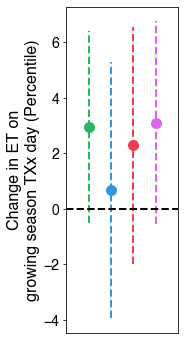

In [51]:
plt.figure(figsize=(2,6))
plt.xlim([0,5])

['#3195e0', '#d1a25c', '#f03c4e', '#2db566']

cur_ms = 10
cur_lw = 2

c_above = '#2db566'
c_below = '#3195e0'
c_shift = '#f03c4e'
c_shift_up = '#dd64ed'

t,p = st.ks_2samp(et_above, et_chg_all)
if p < .05:
    plt.plot(1, np.nanmean(et_above), 'o', ms=cur_ms, c=c_above)
else:
    plt.plot(1, np.nanmean(et_above), 'o', ms=cur_ms, c=c_above, facecolor='none')
plt.plot([1,1], [np.nanmean(et_above)-np.nanstd(et_above)/2, np.nanmean(et_above)+np.nanstd(et_above)/2], '--', c=c_above, lw=cur_lw)

t,p = st.ks_2samp(et_below, et_chg_all)
if p < .05:
    plt.plot(2, np.nanmean(et_below), 'o', ms=cur_ms, c=c_below)
else:
    plt.plot(2, np.nanmean(et_below), 'o', ms=cur_ms, c=c_below, facecolor='none')
plt.plot([2,2], [np.nanmean(et_below)-np.nanstd(et_below)/2, np.nanmean(et_below)+np.nanstd(et_below)/2], '--', c=c_below, lw=cur_lw)

t,p = st.ks_2samp(et_shift, et_chg_all)
if p < .05:
    plt.plot(3, np.nanmean(et_shift), 'o', ms=cur_ms, c=c_shift)
else:
    plt.plot(3, np.nanmean(et_shift), 'o', ms=cur_ms, c=c_shift, facecolor='none')
plt.plot([3,3], [np.nanmean(et_shift)-np.nanstd(et_shift)/2, np.nanmean(et_shift)+np.nanstd(et_shift)/2], '--', c=c_shift, lw=cur_lw)

t,p = st.ks_2samp(et_shift_up, et_chg_all)
if p < .05:
    plt.plot(4, np.nanmean(et_shift_up), 'o', ms=cur_ms, c=c_shift_up)
else:
    plt.plot(4, np.nanmean(et_shift_up), 'o', ms=cur_ms, c=c_shift_up, facecolor='none')
plt.plot([4,4], [np.nanmean(et_shift_up)-np.nanstd(et_shift_up)/2, np.nanmean(et_shift_up)+np.nanstd(et_shift_up)/2], '--', c=c_shift_up, lw=cur_lw)

plt.ylabel('Change in ET on\ngrowing season TXx day (Percentile)')

plt.plot([0,5], [0,0], '--k', lw=2)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# plt.savefig('et-chg-r-t-et-diff.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(2,6))
plt.xlim([0,5])

['#3195e0', '#d1a25c', '#f03c4e', '#2db566']

cur_ms = 10
cur_lw = 2


t,p = st.ks_2samp(tx_above, tx_chg_all)
if p < .05:
    plt.plot(1, np.nanmean(tx_above), 'o', ms=cur_ms, c=c_above)
else:
    plt.plot(1, np.nanmean(tx_above), 'o', ms=cur_ms, c=c_above, facecolor='none')
plt.plot([1,1], [np.nanmean(tx_above)-np.nanstd(tx_above)/2, np.nanmean(tx_above)+np.nanstd(tx_above)/2], '--', c=c_above, lw=cur_lw)

t,p = st.ks_2samp(tx_below, tx_chg_all)
if p < .05:
    plt.plot(2, np.nanmean(tx_below), 'o', ms=cur_ms, c=c_below)
else:
    plt.plot(2, np.nanmean(tx_below), 'o', ms=cur_ms, c=c_below, facecolor='none')
plt.plot([2,2], [np.nanmean(tx_below)-np.nanstd(tx_below)/2, np.nanmean(tx_below)+np.nanstd(tx_below)/2], '--', c=c_below, lw=cur_lw)

t,p = st.ks_2samp(tx_shift, tx_chg_all)
if p < .05:
    plt.plot(3, np.nanmean(tx_shift), 'o', ms=cur_ms, c=c_shift)
else:
    plt.plot(3, np.nanmean(tx_shift), 'o', ms=cur_ms, c=c_shift, facecolor='none')
plt.plot([3,3], [np.nanmean(tx_shift)-np.nanstd(tx_shift)/2, np.nanmean(tx_shift)+np.nanstd(tx_shift)/2], '--', c=c_shift, lw=cur_lw)

t,p = st.ks_2samp(tx_shift_up, tx_chg_all)
if p < .05:
    plt.plot(4, np.nanmean(tx_shift_up), 'o', ms=cur_ms, c=c_shift_up)
else:
    plt.plot(4, np.nanmean(tx_shift_up), 'o', ms=cur_ms, c=c_shift_up, facecolor='none')
plt.plot([4,4], [np.nanmean(tx_shift_up)-np.nanstd(tx_shift_up)/2, np.nanmean(tx_shift_up)+np.nanstd(tx_shift_up)/2], '--', c=c_shift_up, lw=cur_lw)

plt.ylabel('Change in growing season TXx ($\degree$C)')

plt.plot([0,5], [0,0], '--k', lw=2)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.savefig('tx-chg-r-t-et-diff.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(2,6))
plt.xlim([0,5])

['#3195e0', '#d1a25c', '#f03c4e', '#2db566']

cur_ms = 10
cur_lw = 2


t,p = st.ks_2samp(sm_above, sm_chg_all)
if p < .05:
    plt.plot(1, np.nanmean(sm_above), 'o', ms=cur_ms, c=c_above)
else:
    plt.plot(1, np.nanmean(sm_above), 'o', ms=cur_ms, c=c_above, facecolor='none')
plt.plot([1,1], [np.nanmean(sm_above)-np.nanstd(sm_above)/2, np.nanmean(sm_above)+np.nanstd(sm_above)/2], '--', c=c_above, lw=cur_lw)

t,p = st.ks_2samp(sm_below, sm_chg_all)
if p < .05:
    plt.plot(2, np.nanmean(sm_below), 'o', ms=cur_ms, c=c_below)
else:
    plt.plot(2, np.nanmean(sm_below), 'o', ms=cur_ms, c=c_below, facecolor='none')
plt.plot([2,2], [np.nanmean(sm_below)-np.nanstd(sm_below)/2, np.nanmean(sm_below)+np.nanstd(sm_below)/2], '--', c=c_below, lw=cur_lw)

t,p = st.ks_2samp(sm_shift, sm_chg_all)
if p < .05:
    plt.plot(3, np.nanmean(sm_shift), 'o', ms=cur_ms, c=c_shift)
else:
    plt.plot(3, np.nanmean(sm_shift), 'o', ms=cur_ms, c=c_shift, facecolor='none')
plt.plot([3,3], [np.nanmean(sm_shift)-np.nanstd(sm_shift)/2, np.nanmean(sm_shift)+np.nanstd(sm_shift)/2], '--', c=c_shift, lw=cur_lw)

t,p = st.ks_2samp(sm_shift_up, sm_chg_all)
if p < .05:
    plt.plot(4, np.nanmean(sm_shift_up), 'o', ms=cur_ms, c=c_shift_up)
else:
    plt.plot(4, np.nanmean(sm_shift_up), 'o', ms=cur_ms, c=c_shift_up, facecolor='none')
plt.plot([4,4], [np.nanmean(sm_shift_up)-np.nanstd(sm_shift_up)/2, np.nanmean(sm_shift_up)+np.nanstd(sm_shift_up)/2], '--', c=c_shift_up, lw=cur_lw)

plt.ylabel('Change in soil moisture on\ngrowing season TXx day (Percentile)')

plt.plot([0,5], [0,0], '--k', lw=2)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.savefig('sm-chg-r-t-et-diff.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [672]:
cf_bin_step = .01
cf_bins = np.arange(0, 1.01, cf_bin_step)

gridcell_ct = []

r_t_et_61_21_by_cf_bin = {}
r_t_et_61_81_by_cf_bin = {}
r_t_et_71_91_by_cf_bin = {}
r_t_et_81_01_by_cf_bin = {}
r_t_et_81_01_by_cf_bin_soy = {}
r_t_et_81_01_by_cf_bin_wheat = {}
r_t_et_91_11_by_cf_bin = {}
r_t_et_01_21_by_cf_bin = {}
r_t_et_01_21_by_cf_bin_soy = {}
r_t_et_01_21_by_cf_bin_wheat = {}

tx_during_tx_by_cf_bin_1 = np.full([percentiles.size, cf_bins.size], np.nan)
tx_during_tx_by_cf_bin_2 = np.full([percentiles.size, cf_bins.size], np.nan)

tx_amp_81_by_cf_bin = np.full([cf_bins.size], np.nan)
tx_amp_71_by_cf_bin = np.full([cf_bins.size], np.nan)
tx_amp_61_by_cf_bin = np.full([cf_bins.size], np.nan)

maize_yield_chg_by_cf_bin = np.full([cf_bins.size], np.nan)
soy_yield_chg_by_cf_bin = np.full([cf_bins.size], np.nan)
wheat_yield_chg_by_cf_bin = np.full([cf_bins.size], np.nan)

txx_chg_81_by_cf_bin = np.full([cf_bins.size], np.nan)
sm_on_txx_chg_81_by_cf_bin = np.full([cf_bins.size], np.nan)
et_on_txx_chg_81_by_cf_bin = np.full([cf_bins.size], np.nan)

tx_during_tx_trend_by_cf_bin = np.full([cf_bins.size], np.nan)

et_during_tx_by_cf_bin_1 = np.full([percentiles.size, cf_bins.size], np.nan)
et_during_tx_by_cf_bin_2 = np.full([percentiles.size, cf_bins.size], np.nan)

sm_during_tx_by_cf_bin_1 = np.full([percentiles.size, cf_bins.size], np.nan)
sm_during_tx_by_cf_bin_2 = np.full([percentiles.size, cf_bins.size], np.nan)


huss_during_tx_by_cf_bin = []
huss_during_tx_by_cf_bin_1 = []
huss_during_tx_by_cf_bin_2 = []

tw_during_tx_by_cf_bin_1 = np.full([percentiles.size, cf_bins.size], np.nan)
tw_during_tx_by_cf_bin_2 = np.full([percentiles.size, cf_bins.size], np.nan)

tw_during_tw_by_cf_bin_1 = np.full([percentiles.size, cf_bins.size], np.nan)
tw_during_tw_by_cf_bin_2 = np.full([percentiles.size, cf_bins.size], np.nan)


sacks_start_by_cf_bin = []
sacks_end_by_cf_bin = []

cf_var = 'cf'

for c, cur_bin in enumerate(cf_bins):
    
    if c == 0:
        nn = np.where((data[cf_var] < .01))[0]
    elif c == cf_bins.size-1:
        nn = np.where((data[cf_var] > cur_bin-cf_bin_step))[0]
    else:
        nn = np.where(((data[cf_var] > cur_bin-cf_bin_step) & (data['cf'] <= cur_bin)))[0]
    
    gridcell_ct.append(nn.size)
    
    sacks_start_by_cf_bin.append(np.nanmean(data['sacks_start'][nn]))
    sacks_end_by_cf_bin.append(np.nanmean(data['sacks_end'][nn]))
    
    r_t_et_61_21_by_cf_bin[c] = data['r_t_et_61_21'][nn]
    r_t_et_61_81_by_cf_bin[c] = data['r_t_et_61_81'][nn]
    r_t_et_71_91_by_cf_bin[c] = data['r_t_et_71_91'][nn]
    r_t_et_81_01_by_cf_bin[c] = data['r_t_et_81_01'][nn]
    r_t_et_81_01_by_cf_bin_soy[c] = data['r_t_et_81_01_soy'][nn]
    r_t_et_81_01_by_cf_bin_wheat[c] = data['r_t_et_81_01_wheat'][nn]
    r_t_et_91_11_by_cf_bin[c] = data['r_t_et_91_11'][nn]
    r_t_et_01_21_by_cf_bin[c] = data['r_t_et_01_21'][nn]
    r_t_et_01_21_by_cf_bin_soy[c] = data['r_t_et_01_21_soy'][nn]
    r_t_et_01_21_by_cf_bin_wheat[c] = data['r_t_et_01_21_wheat'][nn]
    
    txx_chg_81_by_cf_bin[c] = np.nanmean(data['txx_chg_81_sel_1d'][nn])
    sm_on_txx_chg_81_by_cf_bin[c] = np.nanmean(data['sm_on_txx_chg_81_sel_1d'][nn])
    et_on_txx_chg_81_by_cf_bin[c] = np.nanmean(data['et_on_txx_chg_81_sel_1d'][nn])
    
    maize_yield_chg_by_cf_bin[c] = np.nanmean(data['maize_yield_2'][nn]-data['maize_yield_1'][nn])
    soy_yield_chg_by_cf_bin[c] = np.nanmean(data['soy_yield_2'][nn]-data['soy_yield_1'][nn])
    wheat_yield_chg_by_cf_bin[c] = np.nanmean(data['wheat_yield_2'][nn]-data['wheat_yield_1'][nn])
#     tx_amp_81_by_cf_bin[c] = np.nanmean(data['txx_amp_81'][nn])
#     tx_amp_71_by_cf_bin[c] = np.nanmean(data['txx_amp_71'][nn])
#     tx_amp_61_by_cf_bin[c] = np.nanmean(data['txx_amp_61'][nn])
    
    for p in range(percentiles.size):
        tx_during_tx_by_cf_bin_1[p, c] = np.nanmean(data['tx_during_tx_%d_1'%percentiles[p]][nn])
        tx_during_tx_by_cf_bin_2[p, c] = np.nanmean(data['tx_during_tx_%d_2'%percentiles[p]][nn])
        
        if 'tw_during_tx_%d_1'%percentiles[p] in data.keys():
            tw_during_tx_by_cf_bin_1[p, c] = np.nanmean(data['tw_during_tx_%d_1'%percentiles[p]][nn])
            tw_during_tx_by_cf_bin_2[p, c] = np.nanmean(data['tw_during_tx_%d_2'%percentiles[p]][nn])
        
        if 'et_during_tx_%d_1'%percentiles[p] in data.keys():
            et_during_tx_by_cf_bin_1[p, c] = np.nanmean(data['et_during_tx_%d_1'%percentiles[p]][nn])
            et_during_tx_by_cf_bin_2[p, c] = np.nanmean(data['et_during_tx_%d_2'%percentiles[p]][nn])
            
        if 'sm_during_tx_%d_1'%percentiles[p] in data.keys():
            sm_during_tx_by_cf_bin_1[p, c] = np.nanmean(data['sm_during_tx_%d_1'%percentiles[p]][nn])
            sm_during_tx_by_cf_bin_2[p, c] = np.nanmean(data['sm_during_tx_%d_2'%percentiles[p]][nn])

            
            
        if 'tw_during_tw_%d_1'%percentiles[p] in data.keys():
            tw_during_tw_by_cf_bin_1[p, c] = np.nanmean(data['tw_during_tw_%d_1'%percentiles[p]][nn])
            tw_during_tw_by_cf_bin_2[p, c] = np.nanmean(data['tw_during_tw_%d_2'%percentiles[p]][nn])
   
    tx_during_tx_trend_by_cf_bin[c] = np.nanmean(data['tx_during_tx_trend'][nn])

    huss_during_tx_by_cf_bin_1.append(np.nanmean(data['huss_during_tx_1'][nn]))
    huss_during_tx_by_cf_bin_2.append(np.nanmean(data['huss_during_tx_2'][nn]))
    

    

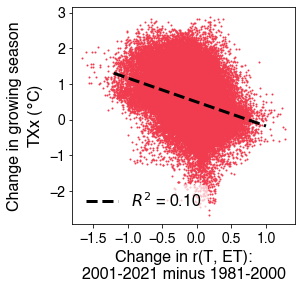

In [669]:
tx_during_tx_chg_binned = data['txx_chg_81_sel_1d']
r_t_et_chg_binned = data['r_t_et_01_21']-data['r_t_et_81_01']

nn = np.where((~np.isnan(tx_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)) & (~np.isnan(data['maize_ha_chg'])))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(tx_during_tx_chg_binned[nn], X).fit()

x1 = -1.2
x2 = 1

plt.figure(figsize=(4,4))

plt.scatter(r_t_et_chg_binned[nn], tx_during_tx_chg_binned[nn], c='#f03c4e', s=1)
l = '$R^2$ = %.2f'%mdl.rsquared
# l = 'Slope =\n%.1f$\degree$C/unit r(T,ET)'%mdl.params[1]
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label=l)

plt.xticks([-1.5, -1, -.5, 0, .5, 1])
plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in growing season\nTXx ($\degree$C)')

legend = plt.legend(prop={'size': 16}, frameon=True, loc='lower left')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('none')
legend.get_frame().set_alpha(0.7)

# plt.legend(prop={'size': 16}, frameon=False, loc='lower left')

plt.savefig('chg-txx-vs-r_t_et_chg-gridcell.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


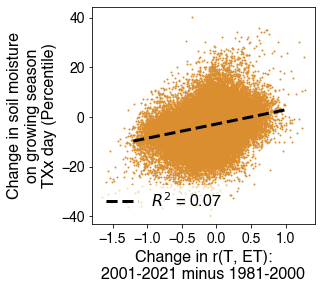

In [670]:



sm_during_tx_chg_binned = data['sm_on_txx_chg_81_sel_1d']
r_t_et_chg_binned = data['r_t_et_01_21']-data['r_t_et_81_01']

nn = np.where((~np.isnan(sm_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)) & (~np.isnan(data['maize_ha_chg'])))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(sm_during_tx_chg_binned[nn], X).fit()

x1 = -1.2
x2 = 1

plt.figure(figsize=(4,4))

plt.scatter(r_t_et_chg_binned[nn], sm_during_tx_chg_binned[nn], c='#db8e30', s=1)

l = '$R^2$ = %.2f'%mdl.rsquared
# l = 'Slope =\n%.1f pp/unit\nr(T,ET)'%mdl.params[1]
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label = l)
plt.xticks([-1.5, -1, -.5, 0, .5, 1])

plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in soil moisture\non growing season\nTXx day (Percentile)')
legend = plt.legend(prop={'size': 16}, frameon=True, loc='lower left')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('none')
legend.get_frame().set_alpha(0.7)

plt.savefig('chg-sm-on-txx-vs-r_t_et_chg-gridcell.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
# divide up grid cells by sacks bin

pct = 95

sacks_start_bins = np.arange(130, 150, 2)
sacks_end_bins = np.arange(240, 270, 3)

tx_during_tx_chg_by_sacks_start = []
tx_during_tx_chg_by_sacks_end = []

for b, cur_bin in enumerate(sacks_start_bins):
    nn = np.where((data['sacks_start'] >= cur_bin) &  (data['sacks_start'] < cur_bin+2))[0]
    tx_during_tx_chg_by_sacks_start.append(np.nanmean(data['tx_during_tx_%d_2'%pct][nn]-data['tx_during_tx_%d_1'%pct][nn]))
    
    nn = np.where((data['sacks_end'] >= cur_bin) &  (data['sacks_end'] < cur_bin+3))[0]
    tx_during_tx_chg_by_sacks_end.append(np.nanmean(data['tx_during_tx_%d_2'%pct][nn]-data['tx_during_tx_%d_1'%pct][nn]))


In [ ]:
plt.plot(tx_during_tx_chg_by_sacks_end)

In [ ]:
plt.plot(sacks_end_by_cf_bin-np.nanmean(sacks_end_by_cf_bin), 'or')
plt.plot(sacks_start_by_cf_bin-np.nanmean(sacks_start_by_cf_bin), 'og')

In [ ]:
r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin[k]-r_t_et_81_01_by_cf_bin[k]) for k in r_t_et_81_01_by_cf_bin.keys()])
plt.plot(cf_bins,r_t_et_chg_binned)

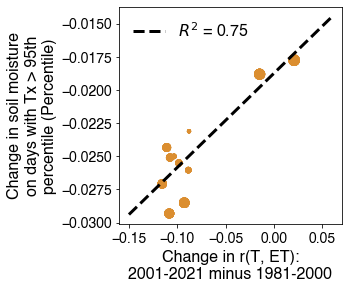

In [603]:
pct = 95

sm_during_tx_chg_binned = sm_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T - sm_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T
r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin[k]-r_t_et_81_01_by_cf_bin[k]) for k in r_t_et_81_01_by_cf_bin.keys()])

nn = np.where((~np.isnan(sm_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(sm_during_tx_chg_binned[nn], X).fit()

x1 = -.15
x2 = 0.06

plt.figure(figsize=(4,4))

plt.scatter(r_t_et_chg_binned[nn], sm_during_tx_chg_binned[nn], c='#db8e30', s=10+cf_bins[nn]*100)
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label='$R^2$ = %.2f'%mdl.rsquared)

plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in soil moisture\non days with Tx > %dth\npercentile (Percentile)'%pct)
plt.legend(prop={'size': 16}, frameon=False)
# plt.savefig('chg-sm-during-tx-95-vs-r_t_et_chg-binned.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
pct = 95

tx_during_tx_chg_binned = tx_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T - tx_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T
r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin[k]-r_t_et_81_01_by_cf_bin[k]) for k in r_t_et_81_01_by_cf_bin.keys()])

nn = np.where((~np.isnan(tx_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(tx_during_tx_chg_binned[nn], X).fit()

x1 = -.15
x2 = 0.06

plt.figure(figsize=(4,4))

plt.scatter(r_t_et_chg_binned, tx_during_tx_chg_binned, c='#f03c4e', s=10+cf_bins*100)

plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label='$R^2$ = %.2f'%mdl.rsquared)

plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in Tx\non days > %dth percentile\n(Percentile)'%pct)
plt.legend(prop={'size': 16}, frameon=False)

# plt.savefig('chg-tx-during-tx-95-vs-r_t_et_chg-binned.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

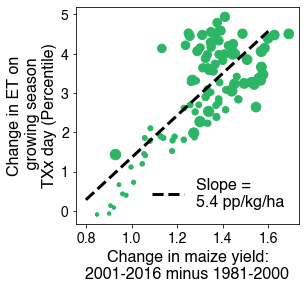

In [77]:


et_during_tx_chg_binned = et_on_txx_chg_81_by_cf_bin

nn = np.where((~np.isnan(et_during_tx_chg_binned)) & (~np.isnan(maize_yield_chg_by_cf_bin)))[0]

X = sm.add_constant(maize_yield_chg_by_cf_bin[nn])
mdl = sm.OLS(et_during_tx_chg_binned[nn], X).fit()

x1 = .8
x2 = 1.6

plt.figure(figsize=(4,4))

plt.scatter(maize_yield_chg_by_cf_bin, et_during_tx_chg_binned, c='#2db566', s=10+cf_bins*100)

# l = '$R^2$ = %.2f'%mdl.rsquared
l = 'Slope =\n%.1f pp/kg/ha'%mdl.params[1]

plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label=l)

plt.xlabel('Change in maize yield:\n2001-2016 minus 1981-2000')
plt.ylabel('Change in ET on\n growing season\nTXx day (Percentile)')
plt.legend(prop={'size': 16}, frameon=False)

plt.savefig('chg-et-on-txx-vs-maize_yield_chg-binned.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


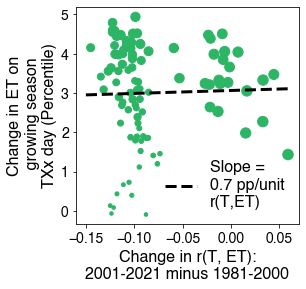

In [75]:



et_during_tx_chg_binned = et_on_txx_chg_81_by_cf_bin
r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin[k]-r_t_et_81_01_by_cf_bin[k]) for k in r_t_et_81_01_by_cf_bin.keys()])

nn = np.where((~np.isnan(et_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(et_during_tx_chg_binned[nn], X).fit()

x1 = -.15
x2 = 0.06

plt.figure(figsize=(4,4))

plt.scatter(r_t_et_chg_binned, et_during_tx_chg_binned, c='#2db566', s=10+cf_bins*100)

# l = '$R^2$ = %.2f'%mdl.rsquared
l = 'Slope =\n%.1f pp/unit\nr(T,ET)'%mdl.params[1]

plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label=l)

plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in ET on\n growing season\nTXx day (Percentile)')
plt.legend(prop={'size': 16}, frameon=False)

# plt.savefig('chg-et-on-txx-vs-r_t_et_chg-binned.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


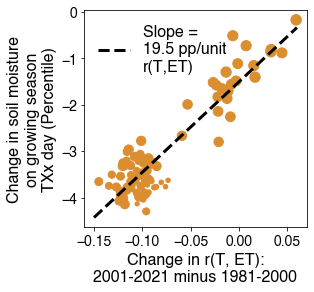

In [673]:



sm_during_tx_chg_binned = sm_on_txx_chg_81_by_cf_bin
r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin[k]-r_t_et_81_01_by_cf_bin[k]) for k in r_t_et_81_01_by_cf_bin.keys()])

nn = np.where((~np.isnan(sm_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(sm_during_tx_chg_binned[nn], X).fit()

x1 = -.15
x2 = 0.06

plt.figure(figsize=(4,4))

plt.scatter(r_t_et_chg_binned, sm_during_tx_chg_binned, c='#db8e30', s=10+cf_bins*100)

# l = '$R^2$ = %.2f'%mdl.rsquared
l = 'Slope =\n%.1f pp/unit\nr(T,ET)'%mdl.params[1]
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label = l)

plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in soil moisture\non growing season\nTXx day (Percentile)')
plt.legend(prop={'size': 16}, frameon=False)

# plt.savefig('chg-sm-on-txx-vs-r_t_et_chg-binned.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [674]:
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     516.3
Date:                Fri, 05 May 2023   Prob (F-statistic):           4.63e-41
Time:                        14:58:28   Log-Likelihood:                -48.780
No. Observations:                 101   AIC:                             101.6
Df Residuals:                      99   BIC:                             106.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5047      0.081    -18.628      0.000      -1.665      -1.344
x1            19.4979      0.858     22.722      0.000      17.795      21.201
==============================================================================
Omnibus:                        0.207   Durbin-Watson:                   1.440
Prob(Omnibus):                  0.902   Jarque-Bera (JB):                0.247
Skew:                           0.104   Prob(JB):                        0.884
Kurtosis:                       2.877   Cond. No.                         21.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
import statsmodels.stats.api as sms


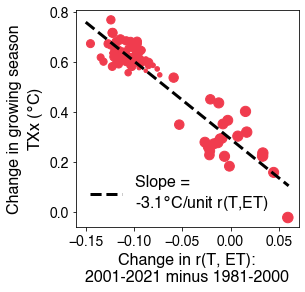

In [285]:
pct = 95

tx_during_tx_chg_binned = txx_chg_81_by_cf_bin
r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin[k]-r_t_et_81_01_by_cf_bin[k]) for k in r_t_et_81_01_by_cf_bin.keys()])

nn = np.where((~np.isnan(tx_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(tx_during_tx_chg_binned[nn], X).fit()

x1 = -.15
x2 = 0.06

plt.figure(figsize=(4,4))

plt.scatter(r_t_et_chg_binned, tx_during_tx_chg_binned, c='#f03c4e', s=10+cf_bins*100)

# l = '$R^2$ = %.2f'%mdl.rsquared
l = 'Slope =\n%.1f$\degree$C/unit r(T,ET)'%mdl.params[1]
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label=l)

plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in growing season\nTXx ($\degree$C)')
plt.legend(prop={'size': 16}, frameon=False)

# plt.savefig('chg-txx-vs-r_t_et_chg-binned.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


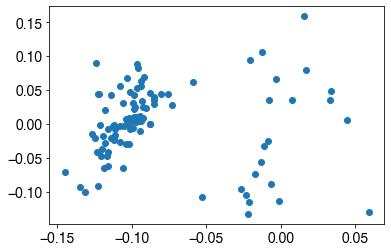

In [103]:
plt.scatter(r_t_et_chg_binned[nn], mdl.resid)

In [104]:
bp_test = sms.het_breuschpagan(mdl.resid, mdl.model.exog)
bp_test_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("\nBreusch-Pagan test:")
print((bp_test_labels, bp_test))


Breusch-Pagan test:
(['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'], (22.187713175219514, 2.472510422249877e-06, 27.871080675914012, 7.682130486949576e-07))


In [99]:
white_test = sms.het_white(mdl.resid, mdl.model.exog)
white_test_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("\nWhite test:")
print(white_test_labels, white_test)


White test:
['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'] (302.24419586867725, 2.3361825382059515e-66, 156.0032207216423, 2.1395694030043634e-67)


In [ ]:

et_on_txx = data['et_on_txx_chg_81_sel_1d']
r_t_et_chg = data['r_t_et_01_21']-data['r_t_et_81_01']

# nn = np.where((~np.isnan(tx_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)))[0]

bins = np.arange(-1,1,.1)
et_on_txx_binned = np.full(bins.shape,np.nan)

for b,bin in enumerate(bins):
    if b < bins.size-1:
        ind = np.where((r_t_et_chg >= bins[b]) & (r_t_et_chg < bins[b+1]))[0]
        et_on_txx_binned[b] = np.nanmean(et_on_txx[ind])

# plt.savefig('chg-txx-vs-r_t_et_chg-binned.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
plt.plot(bins,et_on_txx_binned)

In [ ]:
pct = 95
X = sm.add_constant(data['cf'])
mdl_1 = sm.OLS(data['tx_during_tx_%d_1'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_2 = sm.OLS(data['tx_during_tx_%d_2'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_3 = sm.OLS(data['tx_during_tx_%d_2'%pct]-data['tx_during_tx_%d_1'%pct], X).fit()

fig, ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(cf_bins, tx_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'ob', markersize=10, label='1981-1999\nslope = %.4f, p = %.2f'%(mdl_1.params[1], mdl_1.pvalues[1]))
ax[0].plot([0, 1], [mdl_1.params[0]+0*mdl_1.params[1], mdl_1.params[0]+1*mdl_1.params[1]], '--b', lw=2)

ax[0].plot(cf_bins, tx_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T, 'or', markersize=10, label='2000-2020\nslope = %.4f, p = %.2f'%(mdl_2.params[1], mdl_2.pvalues[1]))
ax[0].plot([0, 1], [mdl_2.params[0]+0*mdl_2.params[1], mdl_2.params[0]+1*mdl_2.params[1]], '--r', lw=2)

ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('Tx during Tx (Tx percentile > %dth)'%pct)
ax[0].legend(prop={'size': 18}, frameon=False)


ax[1].plot(cf_bins, tx_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T - tx_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'om', markersize=10, label='2000-2020 minus 1981-1999\nslope=%.5f, p = %.2f'%(mdl_3.params[1], mdl_3.pvalues[1]))
ax[1].plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].legend(prop={'size': 18}, frameon=False)

# plt.savefig('chg-tx-during-tx-95-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
fig = plt.figure(figsize=(4,4))
plt.plot(cf_bins, tx_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T - tx_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'om', markersize=10, label='p = %.2f'%(mdl_3.pvalues[1]))
plt.plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
plt.xlabel('Crop fraction')
plt.ylabel('Change in Tx\non days > %dth percentile\n(Percentile)'%pct)
plt.legend(prop={'size': 18}, frameon=False)

In [ ]:
pct = 95

X = sm.add_constant(data['cf'])
mdl_1 = sm.OLS(data['et_during_tx_%d_1'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_2 = sm.OLS(data['et_during_tx_%d_2'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_3 = sm.OLS(data['et_during_tx_%d_2'%pct]-data['et_during_tx_%d_1'%pct], X).fit()

fig, ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(cf_bins, et_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'ob', markersize=10, label='1981-1999\nslope = %.4f, p = %.2f'%(mdl_1.params[1], mdl_1.pvalues[1]))
ax[0].plot([0, 1], [mdl_1.params[0]+0*mdl_1.params[1], mdl_1.params[0]+1*mdl_1.params[1]], '--b', lw=2)

ax[0].plot(cf_bins, et_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T, 'or', markersize=10, label='2000-2020\nslope = %.4f, p = %.2f'%(mdl_2.params[1], mdl_2.pvalues[1]))
ax[0].plot([0, 1], [mdl_2.params[0]+0*mdl_2.params[1], mdl_2.params[0]+1*mdl_2.params[1]], '--r', lw=2)

ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('ET during Tx (percentile; > 95th)')
ax[0].legend(prop={'size': 14}, frameon=False)


ax[1].plot(cf_bins, et_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T-et_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'om', markersize=10, label='2000-2020 minus 1981-1999\nslope=%.5f, p = %.2f'%(mdl_3.params[1], mdl_3.pvalues[1]))
ax[1].plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].legend(prop={'size': 14}, frameon=False)

In [ ]:
pct = 95

X = sm.add_constant(data['cf'])
mdl_1 = sm.OLS(data['sm_during_tx_%d_1'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_2 = sm.OLS(data['sm_during_tx_%d_2'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_3 = sm.OLS(data['sm_during_tx_%d_2'%pct]-data['sm_during_tx_%d_1'%pct], X).fit()

fig, ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(cf_bins, sm_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'ob', markersize=10, label='1981-1999\nslope = %.4f, p = %.2f'%(mdl_1.params[1], mdl_1.pvalues[1]))
ax[0].plot([0, 1], [mdl_1.params[0]+0*mdl_1.params[1], mdl_1.params[0]+1*mdl_1.params[1]], '--b', lw=2)

ax[0].plot(cf_bins, sm_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T, 'or', markersize=10, label='2000-2020\nslope = %.4f, p = %.2f'%(mdl_2.params[1], mdl_2.pvalues[1]))
ax[0].plot([0, 1], [mdl_2.params[0]+0*mdl_2.params[1], mdl_2.params[0]+1*mdl_2.params[1]], '--r', lw=2)

ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('Soil moisture during extreme Tx\n(Tx percentile > %dth)'%pct)
ax[0].legend(prop={'size': 18}, frameon=False)


ax[1].plot(cf_bins, sm_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T-sm_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'om', markersize=10, label='2000-2020 minus 1981-1999\nslope=%.5f, p = %.2f'%(mdl_3.params[1], mdl_3.pvalues[1]))
ax[1].plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].legend(prop={'size': 18}, frameon=False)

# plt.savefig('chg-sm-during-tx-95-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

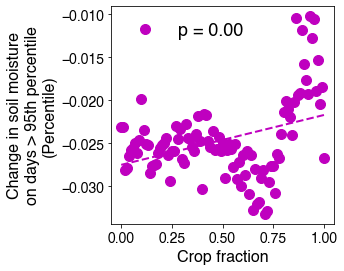

In [573]:
pct=95

cur_x = cf_bins
cur_y = sm_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T-sm_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T

X = sm.add_constant(cur_x)
mdl_3 = sm.OLS(cur_y, X).fit()

fig = plt.figure(figsize=(4,4))
plt.plot(cur_x, cur_y, 'om', markersize=10, label='p = %.2f'%(mdl_3.pvalues[1]))
plt.plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
plt.xlabel('Crop fraction')
plt.ylabel('Change in soil moisture\non days > %dth percentile\n(Percentile)'%pct)
plt.legend(prop={'size': 18}, frameon=False)

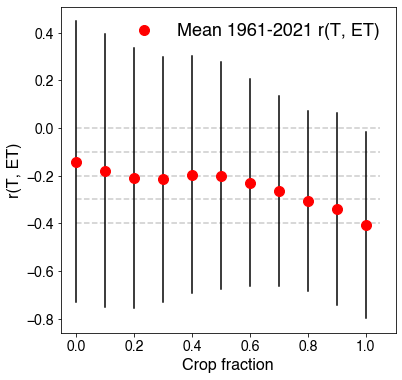

In [584]:

plt.figure(figsize=(6,6))
plt.plot([0,cf_bins.size-.5], [0,0], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.1, -.1], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.2, -.2], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.3, -.3], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.4, -.4], '--', c='#cccccc')
for i, k in  enumerate(r_t_et_61_21_by_cf_bin.keys()):
    m = np.nanmean(r_t_et_61_21_by_cf_bin[k])
    sdev = np.nanstd(r_t_et_61_21_by_cf_bin[k])
    plt.plot([k,k], [m-sdev, m+sdev], c='k')
    if i == 0:
        plt.plot(k, m, 'or', markersize=10, label='Mean 1961-2021 r(T, ET)')
    else:
        plt.plot(k, m, 'or', markersize=10)
    
plt.gca().set_xticks(range(0,cf_bins.size,2))
plt.gca().set_xticklabels(np.round(cf_bins[np.arange(0,cf_bins.size,2)],2))
plt.xlabel('Crop fraction')
plt.ylabel('r(T, ET)')
plt.legend(prop={'size': 18}, frameon=False, loc='upper right')

# plt.savefig('mean-r-t-et-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

0 1.3498816805338771e-49 5.262591925276826e-51
1 6.2114296236937285e-68 5.048433298176154e-195
2 0.14109748424093355 1.9718707677589563e-44
3 0.4265777143709035 6.281713091893541e-37
4 0.2847247379185069 7.0923285214445095e-34
5 0.818951934108913 1.810232495537155e-32
6 0.2289332836453694 9.452177449511427e-40
7 0.25137983730148994 1.5522480996950084e-40
8 0.1386889495751455 3.411128301276062e-26
9 7.375815821517826e-07 0.22017244509910144
10 3.5038994007720234e-08 0.15080822186893852


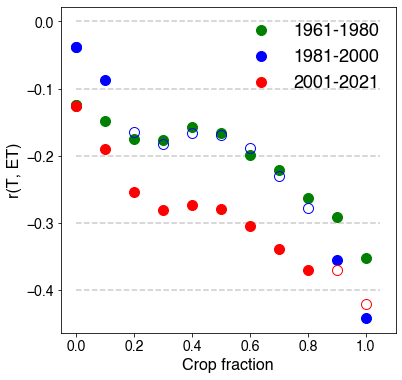

In [602]:
from scipy.stats import mannwhitneyu


plt.figure(figsize=(6,6))
plt.plot([0,cf_bins.size-.5], [0,0], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.1, -.1], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.2, -.2], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.3, -.3], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.4, -.4], '--', c='#cccccc')
for i, k in  enumerate(r_t_et_61_81_by_cf_bin.keys()):
    m1 = np.nanmean(r_t_et_61_81_by_cf_bin[k])
    sdev1 = np.nanstd(r_t_et_81_01_by_cf_bin[k])
    
    m2 = np.nanmean(r_t_et_81_01_by_cf_bin[k])
    sdev2 = np.nanstd(r_t_et_81_01_by_cf_bin[k])
    
    m3 = np.nanmean(r_t_et_01_21_by_cf_bin[k])
    sdev3 = np.nanstd(r_t_et_01_21_by_cf_bin[k])
    
#     t1,p1 = st.ks_2samp(r_t_et_61_81_by_cf_bin[k], r_t_et_81_01_by_cf_bin[k])
#     t2,p2 = st.ks_2samp(r_t_et_81_01_by_cf_bin[k], r_t_et_01_21_by_cf_bin[k])
    
    nn = np.where((~np.isnan(r_t_et_61_81_by_cf_bin[k])) & (~np.isnan(r_t_et_81_01_by_cf_bin[k])) & (~np.isnan(r_t_et_01_21_by_cf_bin[k])))[0]
    
    t1,p1 = st.ttest_ind(r_t_et_61_81_by_cf_bin[k][nn], r_t_et_81_01_by_cf_bin[k][nn])
    t2,p2 = st.ttest_ind(r_t_et_81_01_by_cf_bin[k][nn], r_t_et_01_21_by_cf_bin[k][nn])
    
    
    print(k, p1, p2)
#     plt.plot([k,k], [m-sdev, m+sdev], c='k')
    if i == 0:
        plt.plot(k, m1, 'og', markersize=10, label='1961-1980')
        if p1 < 0.05:
            plt.plot(k, m2, 'ob', markersize=10, label='1981-2000')
        else:
            plt.plot(k, m2, 'ob', markersize=10, label='1981-2000', fillstyle='none')
            
        
        if p2 < 0.01:
            plt.plot(k, m3, 'or', markersize=10, label='2001-2021', alpha=1)
        elif p2 < 0.05:
            plt.plot(k, m3, 'or', markersize=10, label='2001-2021', alpha=.5)
        else: 
            plt.plot(k, m3, 'or', markersize=10, label='2001-2021', fillstyle='none')
        
    plt.plot(k, m1, 'og', markersize=10)
    
    if p1 < 0.01:
        plt.plot(k, m2, 'ob', markersize=10, alpha=1)
    elif p1 < 0.05:
        plt.plot(k, m2, 'ob', markersize=10, alpha=.5)
    else:
        plt.plot(k, m2, 'ob', markersize=10, fillstyle='none')
        
    if p2 < 0.01:
        plt.plot(k, m3, 'or', markersize=10, alpha=1)
    elif p2 < 0.05:
        plt.plot(k, m3, 'or', markersize=10, alpha=.5)
    else:
        plt.plot(k, m3, 'or', markersize=10, fillstyle='none')
    
plt.gca().set_xticks(range(0,cf_bins.size,2))
plt.gca().set_xticklabels(np.round(cf_bins[np.arange(0,cf_bins.size,2)],2))
plt.xlabel('Crop fraction')
plt.ylabel('r(T, ET)')
plt.legend(prop={'size': 18}, frameon=False, loc='upper right')

plt.savefig('chg-r-t-et-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
# tx_during_tx_95_iizumi = tx_during_tx[np.where((percentiles==95))[0][0], 0:36, :, :]
# tx_during_tx_95_iizumi = tx_during_tx_95_iizumi[:, lat_ind_sel,:]

In [ ]:
plt.plot(lat_ind_sel)

In [79]:
# tx_during_tx_95_iizumi = era5_txx.tasmax_grow_max.values[:, lat_ind_sel, :]
tx_during_tx_95_iizumi_maize = era5_tmean_maize.tasmax_grow_mean.values[:, lat_ind_sel, :]
tx_during_tx_95_iizumi_soy = era5_tmean_soy.tasmax_grow_mean.values[:, lat_ind_sel, :]
tx_during_tx_95_iizumi_wheat = era5_tmean_wheat.tasmax_grow_mean.values[:, lat_ind_sel, :]

In [303]:
iizumi_maize_ds_regrid_values = iizumi_maize_ds_regrid['var'].values
iizumi_maize_ds_regrid_values[iizumi_maize_ds_regrid_values==0] = np.nan
iizumi_maize_ds_regrid_values = iizumi_maize_ds_regrid_values[:,lat_ind_sel,:]
iizumi_maize_ds_regrid_values_1d = np.nanmean(iizumi_maize_ds_regrid_values, axis=0)
iizumi_maize_ds_regrid_values_1d = np.reshape(iizumi_maize_ds_regrid_values_1d, [iizumi_maize_ds_regrid_values_1d.size,1])

iizumi_soy_ds_regrid_values = iizumi_soy_ds_regrid['var'].values
iizumi_soy_ds_regrid_values[iizumi_soy_ds_regrid_values==0] = np.nan
iizumi_soy_ds_regrid_values = iizumi_soy_ds_regrid_values[:, lat_ind_sel, :]
iizumi_soy_ds_regrid_values_1d = np.nanmean(iizumi_soy_ds_regrid_values, axis=0)
iizumi_soy_ds_regrid_values_1d = np.reshape(iizumi_soy_ds_regrid_values_1d, [iizumi_soy_ds_regrid_values_1d.size,1])

iizumi_wheat_ds_regrid_values = iizumi_wheat_ds_regrid['var'].values
iizumi_wheat_ds_regrid_values[iizumi_wheat_ds_regrid_values==0] = np.nan
iizumi_wheat_ds_regrid_values = iizumi_wheat_ds_regrid_values[:, lat_ind_sel, :]
iizumi_wheat_ds_regrid_values_1d = np.nanmean(iizumi_wheat_ds_regrid_values, axis=0)
iizumi_wheat_ds_regrid_values_1d = np.reshape(iizumi_wheat_ds_regrid_values_1d, [iizumi_wheat_ds_regrid_values_1d.size,1])


maize_ha_regrid_2005_sel = maize_ha_regrid_2005[lat_ind_sel,:]
maize_ha_regrid_2005_sel_1d = maize_ha_regrid_2005_sel.reshape([maize_ha_regrid_2005_sel.size,])

soy_ha_regrid_2005_sel = soy_ha_regrid_2005[lat_ind_sel,:]
soy_ha_regrid_2005_sel_1d = soy_ha_regrid_2005_sel.reshape([soy_ha_regrid_2005_sel.size,])

wheat_ha_regrid_2005_sel = wheat_ha_regrid_2005[lat_ind_sel,:]
wheat_ha_regrid_2005_sel_1d = wheat_ha_regrid_2005_sel.reshape([wheat_ha_regrid_2005_sel.size,])

19420

In [181]:
from scipy import signal

maize_yield_txx_sensitivity = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
soy_yield_txx_sensitivity = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
wheat_yield_txx_sensitivity = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)

maize_yield_txx_sensitivity_nonsd = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
soy_yield_txx_sensitivity_nonsd = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
wheat_yield_txx_sensitivity_nonsd = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)

for xlim in range(tx_during_tx_95_iizumi_maize.shape[1]):
    if xlim%50==0: print(xlim)
    for ylim in range(tx_during_tx_95_iizumi_maize.shape[2]):
        
        txx_ts = tx_during_tx_95_iizumi_maize[:,xlim,ylim]
        
        maize_yield_ts = iizumi_maize_ds_regrid_values[:,xlim,ylim]
        soy_yield_ts = iizumi_soy_ds_regrid_values[:,xlim,ylim]
        wheat_yield_ts = iizumi_wheat_ds_regrid_values[:,xlim,ylim]
        
        nn = np.where((~np.isnan(txx_ts)) & (~np.isnan(maize_yield_ts)))[0]
        
        if nn.size >= 30:
            # standardized
            txx_ts_detrend = signal.detrend(txx_ts[nn])/np.nanstd(txx_ts)
            maize_yield_ts_detrend = signal.detrend(maize_yield_ts[nn])/np.nanstd(maize_yield_ts)
            X = sm.add_constant(txx_ts_detrend)
            mdl = sm.OLS(maize_yield_ts_detrend, X).fit()
            maize_yield_txx_sensitivity[xlim, ylim] = mdl.params[1]
            
            # non standardized
            txx_ts_detrend = signal.detrend(txx_ts[nn])
            maize_yield_ts_detrend = signal.detrend(maize_yield_ts[nn])
            X = sm.add_constant(txx_ts_detrend)
            mdl = sm.OLS(maize_yield_ts_detrend, X).fit()
            maize_yield_txx_sensitivity_nonsd[xlim, ylim] = mdl.params[1]
        
        txx_ts = tx_during_tx_95_iizumi_soy[:,xlim,ylim]
        nn = np.where((~np.isnan(txx_ts)) & (~np.isnan(soy_yield_ts)))[0]
        
        if nn.size >= 30:
            # standardized
            txx_ts_detrend = signal.detrend(txx_ts[nn])/np.nanstd(txx_ts)
            soy_yield_ts_detrend = signal.detrend(soy_yield_ts[nn])/np.nanstd(soy_yield_ts)
            X = sm.add_constant(txx_ts_detrend)
            mdl = sm.OLS(soy_yield_ts_detrend, X).fit()
            soy_yield_txx_sensitivity[xlim, ylim] = mdl.params[1]
            
            # non standardized
            txx_ts_detrend = signal.detrend(txx_ts[nn])
            soy_yield_ts_detrend = signal.detrend(soy_yield_ts[nn])
            X = sm.add_constant(txx_ts_detrend)
            mdl = sm.OLS(soy_yield_ts_detrend, X).fit()
            soy_yield_txx_sensitivity_nonsd[xlim, ylim] = mdl.params[1]
            
        
        txx_ts = tx_during_tx_95_iizumi_wheat[:,xlim,ylim]
        nn = np.where((~np.isnan(txx_ts)) & (~np.isnan(wheat_yield_ts)))[0]
        
        if nn.size >= 30:
            # standardized
            txx_ts_detrend = signal.detrend(txx_ts[nn])/np.nanstd(txx_ts)
            wheat_yield_ts_detrend = signal.detrend(wheat_yield_ts[nn])/np.nanstd(wheat_yield_ts)
            X = sm.add_constant(txx_ts_detrend)
            mdl = sm.OLS(wheat_yield_ts_detrend, X).fit()
            wheat_yield_txx_sensitivity[xlim, ylim] = mdl.params[1]
            
            # non standardized
            txx_ts_detrend = signal.detrend(txx_ts[nn])
            wheat_yield_ts_detrend = signal.detrend(wheat_yield_ts[nn])
            X = sm.add_constant(txx_ts_detrend)
            mdl = sm.OLS(wheat_yield_ts_detrend, X).fit()
            wheat_yield_txx_sensitivity_nonsd[xlim, ylim] = mdl.params[1]
        

0
50
100
150
200
250
300
350
400
450
500


In [312]:
nn = np.where((~np.isnan(tx_during_tx_sel_1d[0,:].reshape([tx_during_tx_sel_1d[0,:].size,1]))) & \
              (~np.isnan(et_during_tx_sel_1d[0,:].reshape([et_during_tx_sel_1d[0,:].size,1]))) & \
              (~np.isnan(crop_ha_regrid_sel_1d)) & (crop_ha_regrid_sel_1d>0))[0]

nn2_maize = np.where((maize_ha_regrid_2005_sel_1d[nn]>0))[0]
nn2_soy = np.where((soy_ha_regrid_2005_sel_1d[nn]>0))[0]
nn2_wheat = np.where((wheat_ha_regrid_2005_sel_1d[nn]>0))[0]

maize_yield_txx_sensitivity_sel_1d = maize_yield_txx_sensitivity.reshape([maize_yield_txx_sensitivity.size,])
maize_yield_txx_sensitivity_sel_1d = maize_yield_txx_sensitivity_sel_1d[nn][nn2_maize]

maize_yield_txx_sensitivity_nonsd_sel_1d = maize_yield_txx_sensitivity_nonsd.reshape([maize_yield_txx_sensitivity_nonsd.size,])
maize_yield_txx_sensitivity_nonsd_sel_1d = maize_yield_txx_sensitivity_nonsd_sel_1d[nn][nn2_maize]

soy_yield_txx_sensitivity_sel_1d = soy_yield_txx_sensitivity.reshape([soy_yield_txx_sensitivity.size,])
soy_yield_txx_sensitivity_sel_1d = soy_yield_txx_sensitivity_sel_1d[nn][nn2_soy]

soy_yield_txx_sensitivity_nonsd_sel_1d = soy_yield_txx_sensitivity_nonsd.reshape([soy_yield_txx_sensitivity_nonsd.size,])
soy_yield_txx_sensitivity_nonsd_sel_1d = soy_yield_txx_sensitivity_nonsd_sel_1d[nn][nn2_soy]

wheat_yield_txx_sensitivity_sel_1d = wheat_yield_txx_sensitivity.reshape([wheat_yield_txx_sensitivity.size,])
wheat_yield_txx_sensitivity_sel_1d = wheat_yield_txx_sensitivity_sel_1d[nn][nn2_wheat]

wheat_yield_txx_sensitivity_nonsd_sel_1d = wheat_yield_txx_sensitivity_nonsd.reshape([wheat_yield_txx_sensitivity_nonsd.size,])
wheat_yield_txx_sensitivity_nonsd_sel_1d = wheat_yield_txx_sensitivity_nonsd_sel_1d[nn][nn2_wheat]

In [317]:
np.where(~np.isnan(iizumi_soy_ds_regrid_values_1d[nn][nn2_soy][nn3_soy]))[0].size

14472

In [193]:
nn3_maize = np.where((~np.isnan(data['r_t_et_81_16'][nn2_maize])) & (~np.isnan(maize_yield_txx_sensitivity_sel_1d)))[0]

X = sm.add_constant(data['r_t_et_81_16'][nn2_maize][nn3_maize])
mdl_maize_nonsd = sm.OLS(maize_yield_txx_sensitivity_nonsd_sel_1d[nn3_maize], X).fit()

X = sm.add_constant(data['r_t_et_81_16'][nn2_maize][nn3_maize])
mdl_maize = sm.OLS(maize_yield_txx_sensitivity_sel_1d[nn3_maize], X).fit()
mdl_maize.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     9868.
Date:                Wed, 03 May 2023   Prob (F-statistic):               0.00
Time:                        12:04:18   Log-Likelihood:                 4741.7
No. Observations:               33365   AIC:                            -9479.
Df Residuals:                   33363   BIC:                            -9463.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0467      0.001    -37.412      0.000      -0.049      -0.044
x1             0.2268      0.002     99.340      0.000       0.222       0.231
==============================================================================
Omnibus:                     1891.493   Durbin-Watson:                   0.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5742.731
Skew:                          -0.266   Prob(JB):                         0.00
Kurtosis:                       4.962   Cond. No.                         2.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

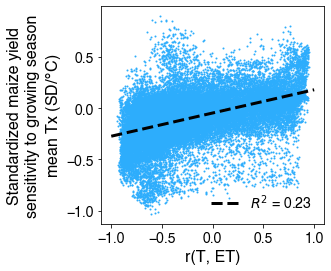

In [286]:
plt.figure(figsize=(4,4))
x1 = -1
x2 = 1
plt.scatter(data['r_t_et_81_16'][nn2_maize][nn3_maize], maize_yield_txx_sensitivity_sel_1d[nn3_maize], c='#2dadfc', s=1)
plt.plot([x1, x2], [mdl_maize.params[0]+mdl_maize.params[1]*x1, mdl_maize.params[0]+mdl_maize.params[1]*x2], '--k', lw=3, label='$R^2$ = %.2f'%(mdl_maize.rsquared))
plt.legend(prop={'size': 14}, frameon=False)
plt.xlabel('r(T, ET)')
plt.ylabel('Standardized maize yield\nsensitivity to growing season\nmean Tx (SD/$\degree$C)')
plt.savefig('maize-yield-sens-rt-et.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [318]:
np.nanmin(iizumi_maize_ds_regrid_values_1d[nn][nn2_maize][nn3_maize][np.where((maize_yield_txx_sensitivity_sel_1d[nn3_maize]>0))[0]])

0.032265021838247775

In [324]:
np.nanmean(iizumi_maize_ds_regrid_values_1d[nn][nn2_maize][nn3_maize][np.where((maize_yield_txx_sensitivity_sel_1d[nn3_maize]>0))[0]])

3.746590944565845

In [319]:
np.where(~np.isnan(iizumi_soy_ds_regrid_values_1d[nn][nn2_soy][nn3_soy]))[0].size

14472

In [305]:
nn3_soy = np.where((~np.isnan(data['r_t_et_81_16_soy'][nn2_soy])) & (~np.isnan(soy_yield_txx_sensitivity_sel_1d)))[0]

X = sm.add_constant(data['r_t_et_81_16_soy'][nn2_soy][nn3_soy])
mdl_soy_nonsd = sm.OLS(soy_yield_txx_sensitivity_nonsd_sel_1d[nn3_soy], X).fit()

X = sm.add_constant(data['r_t_et_81_16_soy'][nn2_soy][nn3_soy])
mdl_soy = sm.OLS(soy_yield_txx_sensitivity_sel_1d[nn3_soy], X).fit()
mdl_soy.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                 1.182e+04
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        10:13:53   Log-Likelihood:                 3077.4
No. Observations:               14472   AIC:                            -6151.
Df Residuals:                   14470   BIC:                            -6136.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0458      0.002    -28.047      0.000      -0.049      -0.043
x1             0.3296      0.003    108.707      0.000       0.324       0.336
==============================================================================
Omnibus:                       63.881   Durbin-Watson:                   0.207
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.289
Skew:                           0.145   Prob(JB):                     4.03e-15
Kurtosis:                       3.160   Cond. No.                         1.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

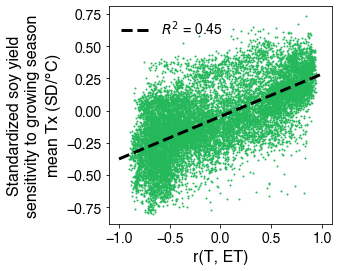

In [287]:
plt.figure(figsize=(4,4))
x1 = -1
x2 = 1
plt.scatter(data['r_t_et_81_16_soy'][nn2_soy][nn3_soy], soy_yield_txx_sensitivity_sel_1d[nn3_soy], c='#25b85b', s=1)
plt.plot([x1, x2], [mdl_soy.params[0]+mdl_soy.params[1]*x1, mdl_soy.params[0]+mdl_soy.params[1]*x2], '--k', lw=3, label='$R^2$ = %.2f'%(mdl_soy.rsquared))
plt.legend(prop={'size': 14}, frameon=False)
plt.xlabel('r(T, ET)')
plt.ylabel('Standardized soy yield\nsensitivity to growing season\nmean Tx (SD/$\degree$C)')
# plt.savefig('soy-yield-sens-rt-et.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [114]:
np.where((soy_yield_txx_sensitivity_sel_1d[nn3_soy]>0))[0].size/nn3_soy.size

0.4098258706467662

In [288]:
nn3_wheat = np.where((~np.isnan(data['r_t_et_81_16_wheat'][nn2_wheat])) & (~np.isnan(wheat_yield_txx_sensitivity_sel_1d)))[0]

X = sm.add_constant(data['r_t_et_81_16_wheat'][nn2_wheat][nn3_wheat])
mdl_wheat_nonsd = sm.OLS(wheat_yield_txx_sensitivity_nonsd_sel_1d[nn3_wheat], X).fit()

X = sm.add_constant(data['r_t_et_81_16_wheat'][nn2_wheat][nn3_wheat])
mdl_wheat = sm.OLS(wheat_yield_txx_sensitivity_sel_1d[nn3_wheat], X).fit()
mdl_wheat.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     3181.
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        10:08:43   Log-Likelihood:                 1674.2
No. Observations:               25172   AIC:                            -3344.
Df Residuals:                   25170   BIC:                            -3328.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1067      0.002    -67.932      0.000      -0.110      -0.104
x1             0.1675      0.003     56.399      0.000       0.162       0.173
==============================================================================
Omnibus:                      334.535   Durbin-Watson:                   0.201
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              262.322
Skew:                          -0.170   Prob(JB):                     1.09e-57
Kurtosis:                       2.632   Cond. No.                         2.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

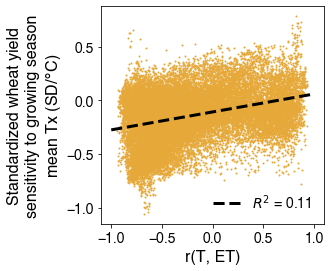

In [289]:
plt.figure(figsize=(4,4))
x1 = -1
x2 = 1
plt.scatter(data['r_t_et_81_16_wheat'][nn2_wheat][nn3_wheat], wheat_yield_txx_sensitivity_sel_1d[nn3_wheat], c='#e6a939', s=1)
plt.plot([x1, x2], [mdl_wheat.params[0]+mdl_wheat.params[1]*x1, mdl_wheat.params[0]+mdl_wheat.params[1]*x2], '--k', lw=3, label='$R^2$ = %.2f'%(mdl_wheat.rsquared))
plt.legend(prop={'size': 14}, frameon=False)
plt.xlabel('r(T, ET)')
plt.ylabel('Standardized wheat yield\nsensitivity to growing season\nmean Tx (SD/$\degree$C)')
plt.savefig('wheat-yield-sens-rt-et.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [117]:
np.where((wheat_yield_txx_sensitivity_sel_1d[nn3_wheat]>0))[0].size/nn3_wheat.size

0.27741140950262194

In [290]:
r_t_et_1_maize = data['r_t_et_81_01'][nn2_maize][nn3_maize]
r_t_et_2_maize = data['r_t_et_01_21'][nn2_maize][nn3_maize]

r_t_et_chg_maize = data['r_t_et_01_21'][nn2_maize][nn3_maize]-data['r_t_et_81_01'][nn2_maize][nn3_maize]

r_t_et_1_maize_low = np.nanpercentile(r_t_et_1_maize, 25)
r_t_et_1_maize_mid = np.nanpercentile(r_t_et_1_maize, 50)
r_t_et_1_maize_high = np.nanpercentile(r_t_et_1_maize, 75)

r_t_et_2_maize_low = np.nanpercentile(r_t_et_2_maize, 25)
r_t_et_2_maize_mid = np.nanpercentile(r_t_et_2_maize, 50)
r_t_et_2_maize_high = np.nanpercentile(r_t_et_2_maize, 75)

r_t_et_chg_maize_low = np.nanpercentile(r_t_et_chg_maize, 25)
r_t_et_chg_maize_mid = np.nanpercentile(r_t_et_chg_maize, 50)
r_t_et_chg_maize_high = np.nanpercentile(r_t_et_chg_maize, 75)

r_t_et_chg_maize_val = np.nanmean(r_t_et_2_maize) - np.nanmean(r_t_et_1_maize)
r_t_et_chg_maize_pct = (-1+np.nanmean(r_t_et_1_maize)/np.nanmean(r_t_et_2_maize))*100
yield_chg_maize = data['maize_yield_2'][nn2_maize][nn3_maize]-data['maize_yield_1'][nn2_maize][nn3_maize]






r_t_et_1_soy = data['r_t_et_81_01_soy'][nn2_soy][nn3_soy]
r_t_et_2_soy = data['r_t_et_01_21_soy'][nn2_soy][nn3_soy]

r_t_et_chg_soy = data['r_t_et_01_21_soy'][nn2_soy][nn3_soy]-data['r_t_et_81_01_soy'][nn2_soy][nn3_soy]
yield_chg_soy = data['soy_yield_2'][nn2_soy][nn3_soy]-data['soy_yield_1'][nn2_soy][nn3_soy]

r_t_et_1_soy_low = np.nanpercentile(r_t_et_1_soy, 25)
r_t_et_1_soy_mid = np.nanpercentile(r_t_et_1_soy, 50)
r_t_et_1_soy_high = np.nanpercentile(r_t_et_1_soy, 75)

r_t_et_2_soy_low = np.nanpercentile(r_t_et_2_soy, 25)
r_t_et_2_soy_mid = np.nanpercentile(r_t_et_2_soy, 50)
r_t_et_2_soy_high = np.nanpercentile(r_t_et_2_soy, 75)

r_t_et_chg_soy_low = np.nanpercentile(r_t_et_chg_soy, 25)
r_t_et_chg_soy_mid = np.nanpercentile(r_t_et_chg_soy, 50)
r_t_et_chg_soy_high = np.nanpercentile(r_t_et_chg_soy, 75)

r_t_et_chg_soy_val = np.nanmean(r_t_et_2_soy) - np.nanmean(r_t_et_1_soy)
r_t_et_chg_soy_pct = (-1+np.nanmean(r_t_et_1_soy)/np.nanmean(r_t_et_2_soy))*100








r_t_et_1_wheat = data['r_t_et_81_01_wheat'][nn2_wheat][nn3_wheat]
r_t_et_2_wheat = data['r_t_et_01_21_wheat'][nn2_wheat][nn3_wheat]

r_t_et_chg_wheat = data['r_t_et_01_21_wheat'][nn2_wheat][nn3_wheat]-data['r_t_et_81_01_wheat'][nn2_wheat][nn3_wheat]
yield_chg_wheat = data['wheat_yield_2'][nn2_wheat][nn3_wheat]-data['wheat_yield_1'][nn2_wheat][nn3_wheat]

r_t_et_1_wheat_low = np.nanpercentile(r_t_et_1_wheat, 25)
r_t_et_1_wheat_mid = np.nanpercentile(r_t_et_1_wheat, 50)
r_t_et_1_wheat_high = np.nanpercentile(r_t_et_1_wheat, 75)

r_t_et_2_wheat_low = np.nanpercentile(r_t_et_2_wheat, 25)
r_t_et_2_wheat_mid = np.nanpercentile(r_t_et_2_wheat, 50)
r_t_et_2_wheat_high = np.nanpercentile(r_t_et_2_wheat, 75)

r_t_et_chg_wheat_low = np.nanpercentile(r_t_et_chg_wheat, 25)
r_t_et_chg_wheat_mid = np.nanpercentile(r_t_et_chg_wheat, 50)
r_t_et_chg_wheat_high = np.nanpercentile(r_t_et_chg_wheat, 75)

r_t_et_chg_wheat_val = np.nanmean(r_t_et_2_wheat)-np.nanmean(r_t_et_1_wheat)
r_t_et_chg_wheat_pct = (-1+np.nanmean(r_t_et_1_wheat)/np.nanmean(r_t_et_2_wheat))*100


In [291]:
maize_yield_txx_sensitivity_chg = mdl_maize.params[1]*r_t_et_chg_maize
soy_yield_txx_sensitivity_chg = mdl_soy.params[1]*r_t_et_chg_soy
wheat_yield_txx_sensitivity_chg = mdl_wheat.params[1]*r_t_et_chg_wheat

maize_yield_txx_sensitivity_2_1d = maize_yield_txx_sensitivity_sel_1d[nn3_maize] + maize_yield_txx_sensitivity_chg
soy_yield_txx_sensitivity_2_1d = soy_yield_txx_sensitivity_sel_1d[nn3_soy] + soy_yield_txx_sensitivity_chg
wheat_yield_txx_sensitivity_2_1d = wheat_yield_txx_sensitivity_sel_1d[nn3_wheat] + wheat_yield_txx_sensitivity_chg

In [292]:
maize_yield_txx_sensitivity_chg_nonsd = mdl_maize_nonsd.params[1]*r_t_et_chg_maize
soy_yield_txx_sensitivity_chg_nonsd = mdl_soy_nonsd.params[1]*r_t_et_chg_soy
wheat_yield_txx_sensitivity_chg_nonsd = mdl_wheat_nonsd.params[1]*r_t_et_chg_wheat

maize_yield_txx_sensitivity_nonsd_2 = maize_yield_txx_sensitivity_nonsd_sel_1d[nn3_maize] + maize_yield_txx_sensitivity_chg_nonsd
soy_yield_txx_sensitivity_nonsd_2 = soy_yield_txx_sensitivity_nonsd_sel_1d[nn3_soy] + soy_yield_txx_sensitivity_chg_nonsd
wheat_yield_txx_sensitivity_nonsd_2 = wheat_yield_txx_sensitivity_nonsd_sel_1d[nn3_wheat] + wheat_yield_txx_sensitivity_chg_nonsd

In [330]:
# production per degree c

prod_maize_1 = iizumi_maize_ds_regrid_values_1d[nn][nn2_maize][nn3_maize].reshape([nn3_maize.size])*maize_ha_regrid_2005_sel_1d[nn][nn2_maize][nn3_maize]
prod_maize_perC_1 = maize_yield_txx_sensitivity_nonsd_sel_1d[nn3_maize] * prod_maize_1
prod_maize_perC_2 = maize_yield_txx_sensitivity_nonsd_2 * prod_maize_1

prod_soy_1 = iizumi_soy_ds_regrid_values_1d[nn][nn2_soy][nn3_soy].reshape([nn3_soy.size])*soy_ha_regrid_2005_sel_1d[nn][nn2_soy][nn3_soy]
prod_soy_perC_1 = soy_yield_txx_sensitivity_nonsd_sel_1d[nn3_soy] * prod_soy_1
prod_soy_perC_2 = soy_yield_txx_sensitivity_nonsd_2 * prod_soy_1

prod_wheat_1 = iizumi_wheat_ds_regrid_values_1d[nn][nn2_wheat][nn3_wheat].reshape([nn3_wheat.size])*wheat_ha_regrid_2005_sel_1d[nn][nn2_wheat][nn3_wheat]
prod_wheat_perC_1 = wheat_yield_txx_sensitivity_nonsd_sel_1d[nn3_wheat] * prod_wheat_1
prod_wheat_perC_2 = wheat_yield_txx_sensitivity_nonsd_2 * prod_wheat_1


print((np.nanmean(prod_maize_perC_2)-np.nanmean(prod_maize_perC_1))/np.nanmean(prod_maize_perC_1))
print((np.nanmean(prod_soy_perC_2)-np.nanmean(prod_soy_perC_1))/np.nanmean(prod_soy_perC_1))
print((np.nanmean(prod_wheat_perC_2)-np.nanmean(prod_wheat_perC_1))/np.nanmean(prod_wheat_perC_1))


0.05536389562056959
0.2087796673876776
0.0772361980260569


In [380]:
lon.size

1440

In [381]:

# Convert latitude and longitude to radians
lat_rad = np.deg2rad(lat)
lon_rad = np.deg2rad(lon)
# Calculate differences in latitudes and longitudes
delta_lat = np.diff(lat_rad)
delta_lon = np.diff(lon_rad)

# Calculate the mean latitude between adjacent points
mean_lat_rad = (lat_rad[:-1] + lat_rad[1:]) / 2

# Calculate the area of each grid cell
earth_radius = 6371000  # in meters
cell_areas = np.outer(
    np.abs(delta_lat) * (earth_radius ** 2) * np.cos(mean_lat_rad),
    np.abs(delta_lon)
) * np.pi / 180  # Convert to steradians

# Convert cell areas to hectares (1 hectare = 10000 square meters)
cell_areas_hectares = cell_areas / 10000
cell_areas_hectares_sel = cell_areas_hectares[lat_ind_sel]

In [544]:
# calc spatially explicit production sensitivity changes

maize_prod_1 = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
maize_prod_2 = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)

soy_prod_1 = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
soy_prod_2 = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)

wheat_prod_1 = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
wheat_prod_2 = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)

maize_prod_chg_per_C = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
soy_prod_chg_per_C = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
wheat_prod_chg_per_C = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)

maize_yield_mean = np.nanmean(iizumi_maize_ds_regrid_values, axis=0)
soy_yield_mean = np.nanmean(iizumi_soy_ds_regrid_values, axis=0)
wheat_yield_mean = np.nanmean(iizumi_wheat_ds_regrid_values, axis=0)

for xlat in range(tx_during_tx_95_iizumi_maize.shape[1]):
    if xlat%50==0: print(xlat)
    for ylon in range(tx_during_tx_95_iizumi_maize.shape[2]-1):
        cur_maize_prod = maize_yield_mean[xlat, ylon] * maize_ha_regrid_2005_sel[xlat, ylon] * cell_areas_hectares_sel[xlat,ylon]
        cur_maize_tet_chg = t_et_01_21[xlat, ylon] - t_et_81_01[xlat, ylon]
        cur_maize_yield_sens_1 = maize_yield_txx_sensitivity_nonsd[xlat, ylon]
        cur_maize_yield_sens_2 = maize_yield_txx_sensitivity_nonsd[xlat, ylon] + mdl_maize_nonsd.params[1]*cur_maize_tet_chg

        cur_maize_prod_perC_1 = cur_maize_yield_sens_1*cur_maize_prod
        cur_maize_prod_perC_2 = cur_maize_yield_sens_2*cur_maize_prod

        maize_prod_1[xlat, ylon] = cur_maize_prod_perC_1
        maize_prod_2[xlat, ylon] = cur_maize_prod_perC_2
        
        
        cur_soy_prod = soy_yield_mean[xlat, ylon] * soy_ha_regrid_2005_sel[xlat, ylon] * cell_areas_hectares_sel[xlat,ylon]
        cur_soy_tet_chg = t_et_01_21_soy[xlat, ylon] - t_et_81_01_soy[xlat, ylon]
        cur_soy_yield_sens_1 = soy_yield_txx_sensitivity_nonsd[xlat, ylon]
        cur_soy_yield_sens_2 = soy_yield_txx_sensitivity_nonsd[xlat, ylon] + mdl_soy_nonsd.params[1]*cur_soy_tet_chg

        cur_soy_prod_perC_1 = cur_soy_yield_sens_1*cur_soy_prod
        cur_soy_prod_perC_2 = cur_soy_yield_sens_2*cur_soy_prod

        soy_prod_1[xlat, ylon] = cur_soy_prod_perC_1
        soy_prod_2[xlat, ylon] = cur_soy_prod_perC_2
        
        
        cur_wheat_prod = wheat_yield_mean[xlat, ylon] * wheat_ha_regrid_2005_sel[xlat, ylon] * cell_areas_hectares_sel[xlat,ylon]
        cur_wheat_tet_chg = t_et_01_21_wheat[xlat, ylon] - t_et_81_01_wheat[xlat, ylon]
        cur_wheat_yield_sens_1 = wheat_yield_txx_sensitivity_nonsd[xlat, ylon]
        cur_wheat_yield_sens_2 = wheat_yield_txx_sensitivity_nonsd[xlat, ylon] + mdl_wheat_nonsd.params[1]*cur_wheat_tet_chg
        
        cur_wheat_prod_perC_1 = cur_wheat_yield_sens_1*cur_wheat_prod
        cur_wheat_prod_perC_2 = cur_wheat_yield_sens_2*cur_wheat_prod
        
        wheat_prod_1[xlat, ylon] = cur_wheat_prod_perC_1
        wheat_prod_2[xlat, ylon] = cur_wheat_prod_perC_2
        


0
50
100
150
200
250
300
350
400
450
500


In [546]:
maize_prod_1_1d = maize_prod_1.reshape([maize_prod_1.size])
maize_prod_2_1d = maize_prod_2.reshape([maize_prod_2.size])
soy_prod_1_1d = soy_prod_1.reshape([soy_prod_1.size])
soy_prod_2_1d = soy_prod_2.reshape([soy_prod_2.size])
wheat_prod_1_1d = wheat_prod_1.reshape([wheat_prod_1.size])
wheat_prod_2_1d = wheat_prod_2.reshape([wheat_prod_2.size])

In [547]:
(np.nansum(maize_prod_2)-np.nansum(maize_prod_1))/np.nansum(maize_prod_1)

0.061012346100486406

In [548]:
(np.nansum(soy_prod_2)-np.nansum(soy_prod_1))/np.nansum(soy_prod_1)

0.2319312260250433

In [549]:
(np.nansum(wheat_prod_2)-np.nansum(wheat_prod_1))/np.nansum(wheat_prod_1)

0.06399914318623352

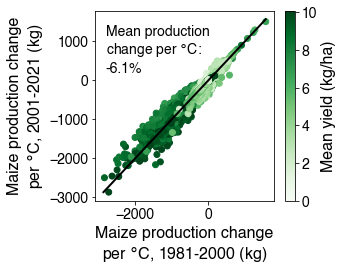

In [567]:
plt.figure(figsize=(4,3.5))
plt.scatter(maize_prod_1, maize_prod_2, c=maize_yield_mean.reshape([maize_yield_mean.size]), cmap='Greens', vmin=0, vmax=10.1)
cb = plt.colorbar()
cb.set_label('Mean yield (kg/ha)')
# plt.plot(np.nanmean(prod_maize_1), np.nanmean(prod_maize_2), 'ok')
x1 = np.nanmin(np.concatenate((maize_prod_2_1d, maize_prod_1_1d)))
x2 = np.nanmax(np.concatenate((maize_prod_2_1d, maize_prod_1_1d)))
plt.plot([x1, x2], [x1, x2], '-k', lw=2)
plt.text(-2800, 200, "Mean production\nchange per $\degree$C:\n%.1f%%"%((np.nansum(maize_prod_2)-np.nansum(maize_prod_1))/np.nansum(maize_prod_1)*-100), fontdict={'family': 'Helvetica', 'size': 14})

plt.xlabel('Maize production change\nper $\degree$C, 1981-2000 (kg)')
plt.ylabel('Maize production change\nper $\degree$C, 2001-2021 (kg)')
plt.savefig('maize-prod-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

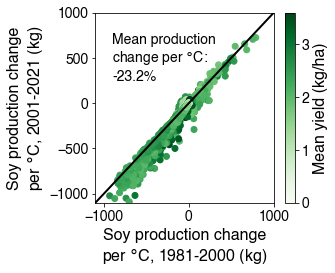

In [568]:
plt.figure(figsize=(4,3.5))
plt.xlim([-1100,1000])
plt.ylim([-1100,1000])
plt.scatter(soy_prod_1, soy_prod_2, c=soy_yield_mean.reshape([soy_yield_mean.size]), cmap='Greens', vmin=0, vmax=3.6)
cb = plt.colorbar()
cb.set_label('Mean yield (kg/ha)')
# plt.plot(np.nanmean(prod_soy_1), np.nanmean(prod_soy_2), 'ok')
x1 = np.nanmin(np.concatenate((soy_prod_2_1d, soy_prod_1_1d)))
x2 = np.nanmax(np.concatenate((soy_prod_2_1d, soy_prod_1_1d)))
plt.plot([x1, x2], [x1, x2], '-k', lw=2)
plt.text(-900, 250, "Mean production\nchange per $\degree$C:\n%.1f%%"%((np.nansum(soy_prod_2)-np.nansum(soy_prod_1))/np.nansum(soy_prod_1)*-100), fontdict={'family': 'Helvetica', 'size': 14})

plt.xlabel('Soy production change\nper $\degree$C, 1981-2000 (kg)')
plt.ylabel('Soy production change\nper $\degree$C, 2001-2021 (kg)')
plt.savefig('soy-prod-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

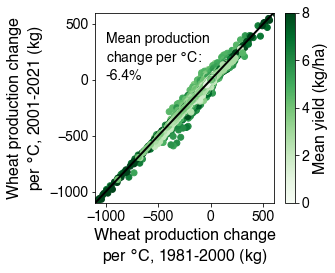

In [569]:
plt.figure(figsize=(4,3.5))
plt.xlim([-1100,600])
plt.ylim([-1100,600])
plt.scatter(wheat_prod_1, wheat_prod_2, c=wheat_yield_mean.reshape([wheat_yield_mean.size]), cmap='Greens', vmin=0, vmax=8)
cb = plt.colorbar()
cb.set_label('Mean yield (kg/ha)')
# plt.plot(np.nanmean(prod_wheat_1), np.nanmean(prod_wheat_2), 'ok')
x1 = np.nanmin(np.concatenate((wheat_prod_2_1d, wheat_prod_1_1d)))
x2 = np.nanmax(np.concatenate((wheat_prod_2_1d, wheat_prod_1_1d)))
plt.plot([x1, x2], [x1, x2], '-k', lw=2)
plt.text(-1000, 0, "Mean production\nchange per $\degree$C:\n%.1f%%"%((np.nansum(wheat_prod_2)-np.nansum(wheat_prod_1))/np.nansum(wheat_prod_1)*-100), fontdict={'family': 'Helvetica', 'size': 14})

plt.xlabel('Wheat production change\nper $\degree$C, 1981-2000 (kg)')
plt.ylabel('Wheat production change\nper $\degree$C, 2001-2021 (kg)')
plt.savefig('wheat-prod-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [233]:


maize_yield_txx_sensitivity_1_low = (np.nanpercentile(maize_yield_txx_sensitivity_sel_1d[nn3_maize], 75))
maize_yield_txx_sensitivity_1_mid = (np.nanpercentile(maize_yield_txx_sensitivity_sel_1d[nn3_maize], 50))
maize_yield_txx_sensitivity_1_high = (np.nanpercentile(maize_yield_txx_sensitivity_sel_1d[nn3_maize], 25))

soy_yield_txx_sensitivity_1_low = (np.nanpercentile(soy_yield_txx_sensitivity_sel_1d[nn3_soy], 75))
soy_yield_txx_sensitivity_1_mid = (np.nanpercentile(soy_yield_txx_sensitivity_sel_1d[nn3_soy], 50))
soy_yield_txx_sensitivity_1_high = (np.nanpercentile(soy_yield_txx_sensitivity_sel_1d[nn3_soy], 25))

wheat_yield_txx_sensitivity_1_low = (np.nanpercentile(wheat_yield_txx_sensitivity_sel_1d[nn3_wheat], 75))
wheat_yield_txx_sensitivity_1_mid = (np.nanpercentile(wheat_yield_txx_sensitivity_sel_1d[nn3_wheat], 50))
wheat_yield_txx_sensitivity_1_high = (np.nanpercentile(wheat_yield_txx_sensitivity_sel_1d[nn3_wheat], 25))


maize_yield_txx_sensitivity_2_low = (np.nanpercentile(maize_yield_txx_sensitivity_2, 75))
maize_yield_txx_sensitivity_2_mid = (np.nanpercentile(maize_yield_txx_sensitivity_2, 50))
maize_yield_txx_sensitivity_2_high = (np.nanpercentile(maize_yield_txx_sensitivity_2, 25))

soy_yield_txx_sensitivity_2_low = (np.nanpercentile(soy_yield_txx_sensitivity_2, 75))
soy_yield_txx_sensitivity_2_mid = (np.nanpercentile(soy_yield_txx_sensitivity_2, 50))
soy_yield_txx_sensitivity_2_high = (np.nanpercentile(soy_yield_txx_sensitivity_2, 25))

wheat_yield_txx_sensitivity_2_low = (np.nanpercentile(wheat_yield_txx_sensitivity_2, 75))
wheat_yield_txx_sensitivity_2_mid = (np.nanpercentile(wheat_yield_txx_sensitivity_2, 50))
wheat_yield_txx_sensitivity_2_high = (np.nanpercentile(wheat_yield_txx_sensitivity_2, 25))


maize_yield_txx_sensitivity_chg_pct = (-1+np.nanmean(maize_yield_txx_sensitivity_sel_1d[nn3_maize])/np.nanmean(maize_yield_txx_sensitivity_2))*100
soy_yield_txx_sensitivity_chg_pct = (-1+np.nanmean(soy_yield_txx_sensitivity_sel_1d[nn3_soy])/np.nanmean(soy_yield_txx_sensitivity_2))*100
wheat_yield_txx_sensitivity_chg_pct = (-1+np.nanmean(wheat_yield_txx_sensitivity_sel_1d[nn3_wheat])/np.nanmean(wheat_yield_txx_sensitivity_2))*100

maize_yield_txx_sensitivity_chg = np.nanmean(maize_yield_txx_sensitivity_2)-np.nanmean(maize_yield_txx_sensitivity_sel_1d[nn3_maize])
soy_yield_txx_sensitivity_chg = np.nanmean(soy_yield_txx_sensitivity_2)-np.nanmean(soy_yield_txx_sensitivity_sel_1d[nn3_soy])
wheat_yield_txx_sensitivity_chg = np.nanmean(wheat_yield_txx_sensitivity_2)-np.nanmean(wheat_yield_txx_sensitivity_sel_1d[nn3_wheat])


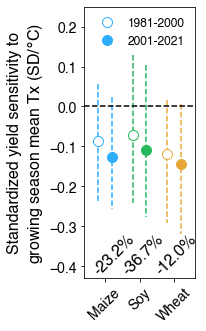

In [571]:

plt.figure(figsize=(2,5))
plt.xlim([.4, 3.6])
plt.ylim([-.43, .25])

plt.plot([.8, .8], [maize_yield_txx_sensitivity_1_low, maize_yield_txx_sensitivity_1_high], '--', c='#2dadfc')
plt.plot(.8, maize_yield_txx_sensitivity_1_mid, 'o', ms=10, c='#2dadfc', mfc='white', label='1981-2000')

plt.plot(1.2,maize_yield_txx_sensitivity_2_mid, 'o', ms=10, c='#2dadfc', label='2001-2021')
plt.plot([1.2, 1.2], [maize_yield_txx_sensitivity_2_low, maize_yield_txx_sensitivity_2_high], '--', c='#2dadfc')
plt.text(1-.4, -.42, \
         '%.1f%%'%(np.round(maize_yield_txx_sensitivity_chg_pct,1)), fontsize=16, fontfamily='helvetica', rotation=45)


plt.plot([1.8, 1.8], [soy_yield_txx_sensitivity_1_low, soy_yield_txx_sensitivity_1_high], '--', c='#25b85b')
plt.plot(1.8,soy_yield_txx_sensitivity_1_mid, 'o', ms=10, c='#25b85b', mfc='white')

plt.plot(2.2,soy_yield_txx_sensitivity_2_mid, 'o', ms=10, c='#25b85b')
plt.plot([2.2,2.2], [soy_yield_txx_sensitivity_2_low, soy_yield_txx_sensitivity_2_high], '--', c='#25b85b')
plt.text(2-.55, -.42, \
         '%.1f%%'%(np.round(soy_yield_txx_sensitivity_chg_pct,1)), fontsize=16, fontfamily='helvetica', rotation=45)


plt.plot([2.8, 2.8], [wheat_yield_txx_sensitivity_1_low, wheat_yield_txx_sensitivity_1_high], '--', c='#e6a939')
plt.plot(2.8,wheat_yield_txx_sensitivity_1_mid, 'o', ms=10, c='#e6a939', mfc='white')

plt.plot([3.2, 3.2], [wheat_yield_txx_sensitivity_2_low, wheat_yield_txx_sensitivity_2_high], '--', c='#e6a939')
plt.plot(3.2,wheat_yield_txx_sensitivity_2_mid, 'o', ms=10, c='#e6a939')

plt.text(3-.62, -.42, \
         '%.1f%%'%(np.round(wheat_yield_txx_sensitivity_chg_pct,1)), fontsize=16, fontfamily='helvetica', rotation=45)
# plt.text(3-.62, -.42, \
#          '%.1f%%'%(np.round(wheat_yield_txx_sensitivity_chg,1)), fontsize=16, fontfamily='helvetica', rotation=45)

plt.plot([.4, 3.6], [0,0], '--k')
plt.gca().set_xticks([1,2,3])
plt.gca().set_xticklabels(['Maize', 'Soy', 'Wheat'], rotation=45)

plt.legend(prop={'size': 12}, frameon=False, loc='upper left')

plt.ylabel('Standardized yield sensitivity to\ngrowing season mean Tx (SD/$\degree$C)')
plt.savefig('crop-sensitivity-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

Text(0, 0.5, 'Change in r(T, ET)\n(2001-2021 minus 1981-2000)')

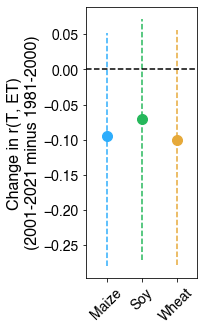

In [236]:
plt.figure(figsize=(2,5))
plt.xlim([.4, 3.6])
# plt.ylim([-20, 30])
plt.plot(1,r_t_et_chg_maize_mid, 'o', ms=10, c='#2dadfc')
plt.plot([1,1], [r_t_et_chg_maize_low, r_t_et_chg_maize_high], '--', c='#2dadfc')
# plt.text(1-.5, maize_yield_txx_sensitivity_chg_std_high+.02, \
#          '%.1f%%'%(np.round(maize_yield_txx_sensitivity_chg_std_mid,1)), fontsize=16, fontfamily='helvetica')

plt.plot(2,r_t_et_chg_soy_mid, 'o', ms=10, c='#25b85b')
plt.plot([2,2], [r_t_et_chg_soy_low, r_t_et_chg_soy_high], '--', c='#25b85b')
# plt.text(2-.5, soy_yield_txx_sensitivity_chg_std_high+.02, \
#          '%.1f%%'%(np.round(soy_yield_txx_sensitivity_chg_std_mid,1)), fontsize=16, fontfamily='helvetica')

plt.plot(3,r_t_et_chg_wheat_mid, 'o', ms=10, c='#e6a939')
plt.plot([3,3], [r_t_et_chg_wheat_low, r_t_et_chg_wheat_high], '--', c='#e6a939')

# plt.text(3-.5, wheat_yield_txx_sensitivity_chg_std_high+.02, \
#          '%.1f%%'%(np.round(wheat_yield_txx_sensitivity_chg_std_mid,1)), fontsize=16, fontfamily='helvetica')

plt.plot([.4, 3.6], [0,0], '--k')
plt.gca().set_xticks([1,2,3])
plt.gca().set_xticklabels(['Maize', 'Soy', 'Wheat'], rotation=45)

plt.ylabel('Change in r(T, ET)\n(2001-2021 minus 1981-2000)')
# plt.savefig('crop-rt-et-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [241]:
r_t_et_chg_maize

array([ 0.35001883,  0.23182632,  0.23881006, ..., -0.05517399,
       -0.08181313, -0.09834422])

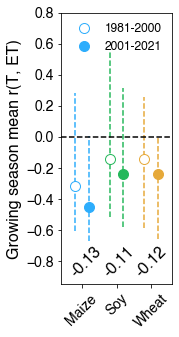

In [572]:

plt.figure(figsize=(2,5))
plt.xlim([.4, 3.6])
plt.ylim([-.95, .8])

plt.plot([.8, .8], [r_t_et_1_maize_low, r_t_et_1_maize_high], '--', c='#2dadfc')
plt.plot(.8, r_t_et_1_maize_mid, 'o', ms=10, c='#2dadfc', mfc='white', label='1981-2000')

plt.plot(1.2,r_t_et_2_maize_mid, 'o', ms=10, c='#2dadfc', label='2001-2021')
plt.plot([1.2, 1.2], [r_t_et_2_maize_low, r_t_et_2_maize_high], '--', c='#2dadfc')
# plt.text(1-.4, -.9, \
#          '%.1f%%'%(np.round(r_t_et_chg_maize_pct,1)), fontsize=16, fontfamily='helvetica', rotation=45)
plt.text(1-.4, -.9, \
         '%.2f'%(np.round(np.nanmean(r_t_et_chg_maize),2)), fontsize=16, fontfamily='helvetica', rotation=45)


plt.plot([1.8, 1.8], [r_t_et_1_soy_low, r_t_et_1_soy_high], '--', c='#25b85b')
plt.plot(1.8,r_t_et_1_soy_mid, 'o', ms=10, c='#25b85b', mfc='white')

plt.plot(2.2,r_t_et_2_soy_mid, 'o', ms=10, c='#25b85b')
plt.plot([2.2,2.2], [r_t_et_2_soy_low, r_t_et_2_soy_high], '--', c='#25b85b')
# plt.text(2-.55, -.9, \
#          '%.1f%%'%(np.round(r_t_et_chg_soy_pct,1)), fontsize=16, fontfamily='helvetica', rotation=45)
plt.text(2-.45, -.9, \
         '%.2f'%(np.round(np.nanmean(r_t_et_chg_soy),2)), fontsize=16, fontfamily='helvetica', rotation=45)


plt.plot([2.8, 2.8], [r_t_et_1_wheat_low, r_t_et_1_wheat_high], '--', c='#e6a939')
plt.plot(2.8,r_t_et_1_soy_mid, 'o', ms=10, c='#e6a939', mfc='white')

plt.plot([3.2, 3.2], [r_t_et_2_wheat_low, r_t_et_2_wheat_high], '--', c='#e6a939')
plt.plot(3.2,r_t_et_2_soy_mid, 'o', ms=10, c='#e6a939')

# plt.text(3-.62, -.9, \
#          '%.1f%%'%(np.round(r_t_et_chg_wheat_pct,1)), fontsize=16, fontfamily='helvetica', rotation=45)
plt.text(3-.52, -.9, \
         '%.2f'%(np.round(np.nanmean(r_t_et_chg_wheat),2)), fontsize=16, fontfamily='helvetica', rotation=45)

plt.plot([.4, 3.6], [0,0], '--k')
plt.gca().set_xticks([1,2,3])
plt.gca().set_xticklabels(['Maize', 'Soy', 'Wheat'], rotation=45)

plt.legend(prop={'size': 12}, frameon=False, loc='upper left')

plt.ylabel('Growing season mean r(T, ET)')
plt.savefig('crop-rt-et-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [349]:
tmp_df = pd.DataFrame({"wheat_ha_regrid_2005_sel_1d": wheat_ha_regrid_2005_sel_1d[nn2_wheat][nn3_wheat], \
                       "yield_chg_wheat": yield_chg_wheat, \
                       "r_t_et_chg_wheat": r_t_et_chg_wheat})
bin_edges = np.arange(0,1,.1)
bins = pd.cut(tmp_df["wheat_ha_regrid_2005_sel_1d"], bin_edges, right=False, include_lowest=True)
wheat_ha_regrid_2005_sel_1d_binned = tmp_df.groupby(bins)["wheat_ha_regrid_2005_sel_1d"].mean().to_numpy()
r_t_et_chg_wheat_binned = tmp_df.groupby(bins)["r_t_et_chg_wheat"].mean().to_numpy()
yield_chg_wheat_binned = tmp_df.groupby(bins)["yield_chg_wheat"].mean().to_numpy()


tmp_df = pd.DataFrame({"maize_ha_regrid_2005_sel_1d": maize_ha_regrid_2005_sel_1d[nn2_maize][nn3_maize], \
                       "yield_chg_maize": yield_chg_maize, \
                       "r_t_et_chg_maize": r_t_et_chg_maize})
bin_edges = np.arange(0,1,.1)
bins = pd.cut(tmp_df["maize_ha_regrid_2005_sel_1d"], bin_edges, right=False, include_lowest=True)
maize_ha_regrid_2005_sel_1d_binned = tmp_df.groupby(bins)["maize_ha_regrid_2005_sel_1d"].mean().to_numpy()
r_t_et_chg_maize_binned = tmp_df.groupby(bins)["r_t_et_chg_maize"].mean().to_numpy()
yield_chg_maize_binned = tmp_df.groupby(bins)["yield_chg_maize"].mean().to_numpy()


# tmp_df = pd.DataFrame({"soy_ha_regrid_2005_sel_1d": soy_ha_regrid_2005_sel_1d[nn2_soy][nn3_soy], \
#                        "yield_chg_soy": yield_chg_soy, \
#                        "r_t_et_chg_soy": r_t_et_chg_soy})
# bin_edges = np.linspace(0, 1, 100)
# bins = pd.cut(tmp_df["soy_ha_regrid_2005_sel_1d"], bin_edges, right=False, include_lowest=True)
# r_t_et_chg_soy_binned = tmp_df.groupby(bins)["r_t_et_chg_soy"].mean().to_numpy()
# yield_chg_soy_binned = tmp_df.groupby(bins)["yield_chg_soy"].mean().to_numpy()


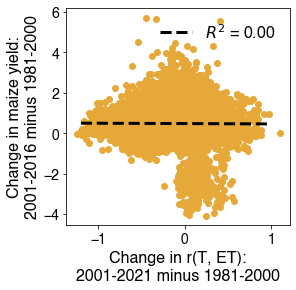

In [138]:


nn = np.where((~np.isnan(r_t_et_chg_wheat)) & (~np.isnan(yield_chg_wheat)))[0]


X = sm.add_constant(r_t_et_chg_wheat[nn])
mdl1 = sm.OLS(yield_chg_wheat[nn], X).fit()

x1 = -1.2
x2 = 1

plt.figure(figsize=(4,4))

# plt.scatter(r_t_et_chg_binned, maize_yield_chg_by_cf_bin, c='#2dadfc', s=10+cf_bins*100)
# plt.scatter(r_t_et_chg_binned, soy_yield_chg_by_cf_bin, c='#25b85b', s=10+cf_bins*100)
plt.scatter(r_t_et_chg_wheat, yield_chg_wheat, c='#e6a939')

plt.plot([x1, x2], [mdl1.params[0]+x1*mdl1.params[1], mdl1.params[0]+x2*mdl1.params[1]], '--k', lw=3, label='$R^2$ = %.2f'%mdl1.rsquared)

plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in maize yield:\n2001-2016 minus 1981-2000')
plt.legend(prop={'size': 16}, frameon=False)

# plt.savefig('chg-r-t-et-vs-chg-yield-wheat.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


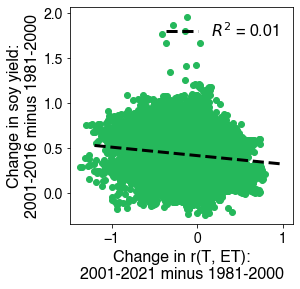

In [139]:


nn = np.where((~np.isnan(r_t_et_chg_soy)) & (~np.isnan(yield_chg_soy)))[0]


X = sm.add_constant(r_t_et_chg_soy[nn])
mdl1 = sm.OLS(yield_chg_soy[nn], X).fit()

x1 = -1.2
x2 = 1

plt.figure(figsize=(4,4))

# plt.scatter(r_t_et_chg_binned, soy_yield_chg_by_cf_bin, c='#2dadfc', s=10+cf_bins*100)
# plt.scatter(r_t_et_chg_binned, soy_yield_chg_by_cf_bin, c='#25b85b', s=10+cf_bins*100)
plt.scatter(r_t_et_chg_soy, yield_chg_soy, c='#25b85b')

plt.plot([x1, x2], [mdl1.params[0]+x1*mdl1.params[1], mdl1.params[0]+x2*mdl1.params[1]], '--k', lw=3, label='$R^2$ = %.2f'%mdl1.rsquared)

plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in soy yield:\n2001-2016 minus 1981-2000')
plt.legend(prop={'size': 16}, frameon=False)

plt.savefig('chg-r-t-et-vs-chg-yield-soy.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


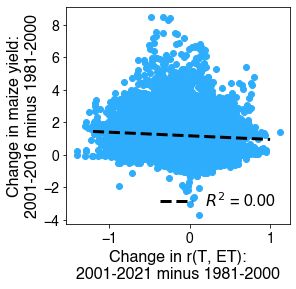

In [140]:


nn = np.where((~np.isnan(r_t_et_chg_maize)) & (~np.isnan(yield_chg_maize)))[0]


X = sm.add_constant(r_t_et_chg_maize[nn])
mdl1 = sm.OLS(yield_chg_maize[nn], X).fit()

x1 = -1.2
x2 = 1

plt.figure(figsize=(4,4))

# plt.scatter(r_t_et_chg_binned, maize_yield_chg_by_cf_bin, c='#2dadfc', s=10+cf_bins*100)
# plt.scatter(r_t_et_chg_binned, soy_yield_chg_by_cf_bin, c='#25b85b', s=10+cf_bins*100)
plt.scatter(r_t_et_chg_maize, yield_chg_maize, c='#2dadfc')

plt.plot([x1, x2], [mdl1.params[0]+x1*mdl1.params[1], mdl1.params[0]+x2*mdl1.params[1]], '--k', lw=3, label='$R^2$ = %.2f'%mdl1.rsquared)

plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in maize yield:\n2001-2016 minus 1981-2000')
plt.legend(prop={'size': 16}, frameon=False)

plt.savefig('chg-r-t-et-vs-chg-yield-maize.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:


plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.3
v2 = 0
vstep = .05
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

map_data = np.full([lat.size, lon.size],np.nan)
map_data[lat_ind_sel,:] = wheat_prod_tx_sensitivity

c = plt.pcolormesh(lon, lat, map_data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season r(T, ET), 2001 - 2021', fontsize=20)

# plt.savefig('growing-season-r-t-et-map-01-21.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
tx_during_tx_95_chg = data['tx_during_tx_%d_2'%95]-data['tx_during_tx_%d_1'%95]
sm_during_tx_95_chg = data['sm_during_tx_%d_2'%95]-data['sm_during_tx_%d_1'%95]
r_t_et_chg = data['r_t_et_3'] - data['r_t_et_2']
nn = np.where((~np.isnan(tx_during_tx_95_chg)) & (~np.isnan(sm_during_tx_95_chg)))[0]

X = sm.add_constant(sm_during_tx_95_chg[nn])
mdl = sm.OLS(tx_during_tx_95_chg[nn], X).fit()


x1 = -.3
x2 = .2
plt.figure(figsize=(6,6))
plt.scatter(sm_during_tx_95_chg, tx_during_tx_95_chg, c='#42b9ff', s=4)
plt.plot([x1, x2], [mdl.params[0] + x1*mdl.params[1], mdl.params[0] + x2*mdl.params[1]], '--k', lw=3, label='Slope: %.3f\np = %.2f'%(mdl.params[1], mdl.pvalues[1]))
plt.xlabel('Change in soil moisture during extreme Tx')
plt.ylabel('Change in extreme Tx')
plt.legend(prop={'size': 16}, frameon=False, loc='lower left')

In [ ]:
tx_during_tx_95_chg = data['tx_during_tx_%d_2'%95]-data['tx_during_tx_%d_1'%95]
et_during_tx_95_chg = data['et_during_tx_%d_2'%95]-data['et_during_tx_%d_1'%95]

nn = np.where((~np.isnan(tx_during_tx_95_chg)) & (~np.isnan(et_during_tx_95_chg)))[0]

X = sm.add_constant(tx_during_tx_95_chg[nn])
mdl = sm.OLS(et_during_tx_95_chg[nn], X).fit()


x1 = -.005
x2 = .01
plt.figure(figsize=(6,6))
plt.scatter(tx_during_tx_95_chg, et_during_tx_95_chg, c='#42b9ff', s=4)
plt.plot([x1, x2], [mdl.params[0] + x1*mdl.params[1], mdl.params[0] + x2*mdl.params[1]], '--k', lw=3)
plt.xlabel('Change in extreme Tx')
plt.ylabel('Change in ET during extreme Tx')